<a href="https://www.kaggle.com/code/tvt2404/dacshutech?scriptVersionId=234298419" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## DDoS Defense: A Multiclass and Multidimensional Detection System with Diverse Machine Learning Models
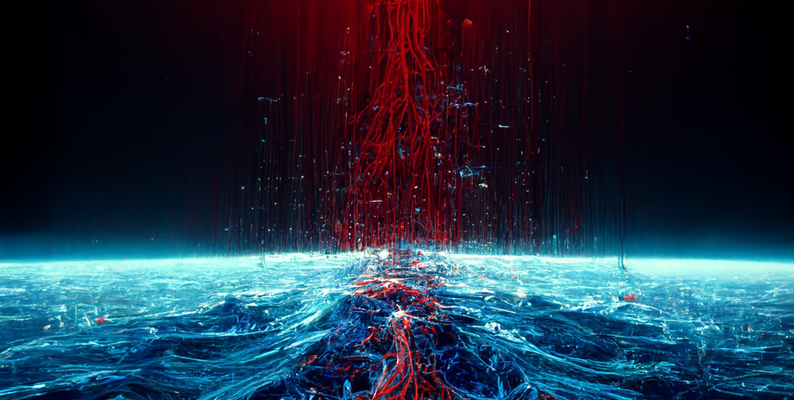
### Project Overview

This project is focused on building a system to detect and classify **DDoS (Distributed Denial of Service)** attacks using the **CICDDoS2019** dataset. The goal is to develop a multiclass classification model that can identify various DDoS attacks from normal network traffic. The dataset consists of multiple attack types with different network traffic characteristics, making it a challenging problem for DDoS detection.

### Dataset Description

The **CICDDoS2019** dataset, provided by the Canadian Institute for Cybersecurity (CIC), contains network traffic data representing several types of DDoS attacks along with benign (non-attack) traffic. The dataset features several attributes like packet size, source/destination IPs, and protocol types. The target variable consists of different attack labels as follows:

- **Syn**: SYN flood attack
- **Benign**: Normal, non-attack traffic
- **Portmap**: Portmapper-based DDoS attack
- **UDP**: Generic UDP flood attack
- **UDPLag**: UDP-based DDoS with lag
- **MSSQL**: MSSQL-specific DDoS attack
- **NetBIOS**: NetBIOS-related DDoS attack
- **LDAP**: Lightweight Directory Access Protocol-based attack

### Process Overview

#### Data Collection and Preprocessing
1. **Collecting Data Paths**:
   - The paths of training and testing datasets are collected using a file walk through. 
   - We ensure that only the datasets with matching names are used for training and testing.

2. **Data Processing**:
   - **Column Mapping**: We map the column names between the training and testing datasets, ensuring they are consistent. The column names in the testing set are renamed to match the training set.
   - **Null and Duplicate Handling**: We check for any null or duplicate values. No null values are found, and any duplicates in the dataset are removed.
   - **Removing Single Unique Value Columns**: Columns with only a single unique value are dropped as they do not provide meaningful information for classification.
   - **Removing Highly Correlated Columns**: Columns with a correlation coefficient of 0.8 or higher are dropped to reduce multicollinearity and improve model performance.

#### Exploratory Data Analysis (EDA)
Several key visualizations were performed to understand the dataset:

- **Distribution of Categorical Columns**: 
   - Frequency distribution using bar plots and percentage distribution using pie charts for categorical features.
- **Flow Duration Distribution**: 
   - Analyzing the flow duration distribution for both DDoS and normal traffic.
- **Packet Length Mean by Protocol and Attack Label**: 
   - Exploring the average packet length by protocol type and attack label.
- **Flags Distribution by Attack Label**: 
   - Distribution of different flag types across attack labels.
- **Protocol Requests Distribution**: 
   - Number of requests coming from different protocols.
- **Correlation Matrix**: 
   - A heatmap to visualize the correlation matrix and identify relationships between features.

#### Data Preprocessing and Feature Engineering
- **Train-Test Split**: 
   - The dataset is split into training, validation, and test sets to ensure proper evaluation of the model.
- **Feature Encoding**: 
   - The target column is encoded using **LabelEncoder** to convert categorical labels into numerical values for training.
- **Feature Scaling**: 
   - We apply **Min-Max Scaling** to scale the features to a uniform range, improving the performance of distance-based algorithms.

#### Model Training and Evaluation
- **Model Selection**: 
   - Several models are trained and evaluated for multiclass classification, including:
     - **Tranfomer**
     - **Convolutional Neural Network (CNN)**
     - **Long Short-Term Memory (LSTM)**
   
- **Model Evaluation**:
   - We evaluate the models using various performance metrics like **accuracy**, **precision**, **recall**, **F1-score**, and **ROC AUC**.
   - ROC curves are plotted to compare the performance of each model across different classes.
   - A table of the model scores is created and displayed for easy comparison.

#### Results Visualization
- **Model Comparison**: 
   - We plot the **accuracy score** for each model to visually compare their performance.
   - ROC curves for all models are plotted to analyze their classification ability, especially for multiclass classification tasks.


## Import Libraries

In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import matplotlib.cm as cm
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve

# Thêm các thư viện cho CNN, LSTM và Transformer
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, Input, MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization, GlobalAveragePooling1D, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Collecting Training and Testing Dataset File Paths
dfps_train = []
dfps_test = []

for dirname, _, filenames in os.walk('/kaggle/input/cicddos2019/'):
    for filename in filenames:
        if filename.endswith('-training.parquet'):
            dfp = os.path.join(dirname, filename)
            dfps_train.append(dfp)
            print(dfp)
        elif filename.endswith('-testing.parquet'):
            dfp = os.path.join(dirname, filename)
            dfps_test.append(dfp)
            print(dfp)

/kaggle/input/cicddos2019/Syn-training.parquet
/kaggle/input/cicddos2019/UDPLag-testing.parquet
/kaggle/input/cicddos2019/NetBIOS-testing.parquet
/kaggle/input/cicddos2019/Portmap-training.parquet
/kaggle/input/cicddos2019/Syn-testing.parquet
/kaggle/input/cicddos2019/MSSQL-testing.parquet
/kaggle/input/cicddos2019/SNMP-testing.parquet
/kaggle/input/cicddos2019/UDPLag-training.parquet
/kaggle/input/cicddos2019/NTP-testing.parquet
/kaggle/input/cicddos2019/LDAP-testing.parquet
/kaggle/input/cicddos2019/UDP-training.parquet
/kaggle/input/cicddos2019/NetBIOS-training.parquet
/kaggle/input/cicddos2019/DNS-testing.parquet
/kaggle/input/cicddos2019/UDP-testing.parquet
/kaggle/input/cicddos2019/LDAP-training.parquet
/kaggle/input/cicddos2019/TFTP-testing.parquet
/kaggle/input/cicddos2019/MSSQL-training.parquet


In [3]:
# Common Prefixes in both lists
train_prefixes = [dfp.split('/')[-1].split('-')[0] for dfp in dfps_train]
test_prefixes = [dfp.split('/')[-1].split('-')[0] for dfp in dfps_test]

common_prefixes = list(set(train_prefixes).intersection(test_prefixes))

# Filter the dataframes to only include the common prefixes
dfps_train = [dfp for dfp in dfps_train if dfp.split('/')[-1].split('-')[0] in common_prefixes]
dfps_test = [dfp for dfp in dfps_test if dfp.split('/')[-1].split('-')[0] in common_prefixes]

In [4]:
train_df = pd.concat([pd.read_parquet(dfp) for dfp in dfps_train], ignore_index=True)
test_df = pd.concat([pd.read_parquet(dfp) for dfp in dfps_test], ignore_index=True)

In [5]:
print(train_df.shape, test_df.shape)

(120065, 78) (38973, 78)


In [6]:
train_df.head()

Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0         6            105                  2                       2   
1         6              1                  2                       0   
2         6       55295858                  8                       0   
3         6             49                  2                       0   
4         6            109                  2                       2   

   Fwd Packets Length Total  Bwd Packets Length Total  Fwd Packet Length Max  \
0                      12.0                      12.0                    6.0   
1                      12.0                       0.0                    6.0   
2                      48.0                       0.0                    6.0   
3                      12.0                       0.0                    6.0   
4                      12.0                      12.0                    6.0   

   Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  ...  \
0                    6.0                     6.0                    0.0  ...   
1                    6.0                     6.0                    0.0  ...   
2                    6.0                     6.0                    0.0  ...   
3                    6.0                     6.0                    0.0  ...   
4                    6.0                     6.0                    0.0  ...   

   Fwd Seg Size Min  Active Mean  Active Std  Active Max  Active Min  \
0                20          0.0         0.0         0.0         0.0   
1                20          0.0         0.0         0.0         0.0   
2                20          1.0         0.0         1.0         1.0   
3                20          0.0         0.0         0.0         0.0   
4                20          0.0         0.0         0.0         0.0   

    Idle Mean   Idle Std    Idle Max    Idle Min  Label  
0         0.0        0.0         0.0         0.0    Syn  
1         0.0        0.0         0.0         0.0    Syn  
2  18431952.0  4641289.0  22000140.0  13184826.0    Syn  
3         0.0        0.0         0.0         0.0    Syn  
4         0.0        0.0         0.0         0.0    Syn  

[5 rows x 78 columns]

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120065 entries, 0 to 120064
Data columns (total 78 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Protocol                  120065 non-null  int8   
 1   Flow Duration             120065 non-null  int32  
 2   Total Fwd Packets         120065 non-null  int32  
 3   Total Backward Packets    120065 non-null  int16  
 4   Fwd Packets Length Total  120065 non-null  float32
 5   Bwd Packets Length Total  120065 non-null  float32
 6   Fwd Packet Length Max     120065 non-null  float32
 7   Fwd Packet Length Min     120065 non-null  float32
 8   Fwd Packet Length Mean    120065 non-null  float32
 9   Fwd Packet Length Std     120065 non-null  float32
 10  Bwd Packet Length Max     120065 non-null  float32
 11  Bwd Packet Length Min     120065 non-null  float32
 12  Bwd Packet Length Mean    120065 non-null  float32
 13  Bwd Packet Length Std     120065 non-null  f

In [8]:
train_df.describe()

Protocol  Flow Duration  Total Fwd Packets  \
count  120065.000000   1.200650e+05      120065.000000   
mean        9.847882   2.052619e+07           9.494665   
std         5.306882   2.995552e+07         356.316717   
min         0.000000   1.000000e+00           1.000000   
25%         6.000000   4.110000e+02           2.000000   
50%         6.000000   1.096240e+05           4.000000   
75%        17.000000   4.531427e+07          10.000000   
max        17.000000   1.199975e+08       86666.000000   

       Total Backward Packets  Fwd Packets Length Total  \
count           120065.000000             120065.000000   
mean                 5.229134                793.607422   
std                 46.543910               2773.197998   
min                  0.000000                  0.000000   
25%                  0.000000                 36.000000   
50%                  2.000000                 72.000000   
75%                  4.000000               1076.000000   
max               8029.000000             208524.000000   

       Bwd Packets Length Total  Fwd Packet Length Max  Fwd Packet Length Min  \
count              1.200650e+05          120065.000000          120065.000000   
mean               2.857971e+03             193.468842             124.397636   
std                7.461836e+04             362.685333             250.985764   
min                0.000000e+00               0.000000               0.000000   
25%                0.000000e+00               6.000000               6.000000   
50%                1.200000e+01               6.000000               6.000000   
75%                3.600000e+01             388.000000              52.000000   
max                1.289243e+07            3625.000000            2131.000000   

       Fwd Packet Length Mean  Fwd Packet Length Std  ...  \
count           120065.000000          120065.000000  ...   
mean               139.754761              23.783617  ...   
std                255.343307              89.581734  ...   
min                  0.000000               0.000000  ...   
25%                  6.000000               0.000000  ...   
50%                  6.000000               0.000000  ...   
75%                262.511108               7.905694  ...   
max               2131.000000            1448.583008  ...   

       Fwd Act Data Packets  Fwd Seg Size Min   Active Mean    Active Std  \
count         120065.000000      1.200650e+05  1.200650e+05  1.200650e+05   
mean               5.671170     -1.248534e+07  7.801130e+04  7.839448e+04   
std               19.933391      1.145488e+08  4.511411e+05  3.852113e+05   
min                0.000000     -1.408238e+09  0.000000e+00  0.000000e+00   
25%                1.000000      2.000000e+01  0.000000e+00  0.000000e+00   
50%                3.000000      2.000000e+01  0.000000e+00  0.000000e+00   
75%                7.000000      2.000000e+01  3.766667e+01  3.323402e+01   
max             3888.000000      6.724045e+07  4.050800e+07  1.063756e+07   

         Active Max    Active Min    Idle Mean     Idle Std     Idle Max  \
count  1.200650e+05  1.200650e+05     120065.0    120065.00     120065.0   
mean   1.821768e+05  3.275870e+04    6264209.5   1559991.25    7932698.0   
std    8.235640e+05  3.747179e+05   10536990.0   3190672.00   12437144.0   
min    0.000000e+00  0.000000e+00          0.0         0.00          0.0   
25%    0.000000e+00  0.000000e+00          0.0         0.00          0.0   
50%    0.000000e+00  0.000000e+00          0.0         0.00          0.0   
75%    1.010000e+02  1.000000e+00   12203672.0   2413746.50   15799887.0   
max    4.050800e+07  4.050800e+07  117569200.0  69614024.00  117569200.0   

          Idle Min  
count     120065.0  
mean     4813855.0  
std      9490017.0  
min            0.0  
25%            0.0  
50%            0.0  
75%      7754443.0  
max    117569200.0  

[8 rows x 77 columns]

## Data Preprocessing

In [9]:
# Check the target distribution of the training data
print(train_df["Label"].value_counts())

Label
Syn        48840
Benign     42007
UDP        18090
MSSQL       8523
LDAP        1906
NetBIOS      644
UDPLag        55
Name: count, dtype: int64


In [10]:
# Check the target distribution of the testing data
print(test_df["Label"].value_counts())

Label
Benign           10847
DrDoS_UDP        10420
UDP-lag           8872
DrDoS_MSSQL       6212
DrDoS_LDAP        1440
DrDoS_NetBIOS      598
Syn                533
WebDDoS             51
Name: count, dtype: int64


The `WebDDoS` label is not present in the training data, so we will not be able to use it for training. We will remove it from the testing data.

In [11]:
# Drop the WebDDoS class from the testing data
test_df = test_df[test_df["Label"] != "WebDDoS"]

The target column values are not matching in the training and testing data. We will replace the target values in the testing data with the values present in the training data.

In [12]:
# Map the labels to the same format
label_mapping = {
    'DrDoS_UDP': 'UDP',
    'UDP-lag': 'UDPLag',
    'DrDoS_MSSQL': 'MSSQL',
    'DrDoS_LDAP': 'LDAP',
    'DrDoS_NetBIOS': 'NetBIOS',
    'Syn': 'Syn',  # Already matches
    'Benign': 'Benign'  # Already matches
}

test_df["Label"] = test_df["Label"].map(label_mapping)

In [13]:
# Check the target distribution of the testing data after mapping
print(test_df["Label"].value_counts())

Label
Benign     10847
UDP        10420
UDPLag      8872
MSSQL       6212
LDAP        1440
NetBIOS      598
Syn          533
Name: count, dtype: int64


In [14]:
# Display the columns of the training data
train_df.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Fla

#### Find the categorical columns, numerical columns, categorical but high cardinality columns.

In [15]:
def grab_col_names(data, cat_th=10, car_th=20):
    # Categorical columns and categorical but high-cardinality columns
    cat_cols = [col for col in data.columns if data[col].dtypes == "O"]
    num_but_cat = [col for col in data.columns if data[col].nunique() < cat_th and data[col].dtypes != "O"]
    high_card_cat_cols = [col for col in data.columns if data[col].nunique() > car_th and data[col].dtypes == "O"]

    # Combine Object type columns and Low-unique-value numeric columns into cat_cols
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in high_card_cat_cols]

    # Numerical columns excluding those considered as categorical
    num_cols = [col for col in data.columns if data[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # Display information about the dataset
    print(f"Observations: {data.shape[0]}")
    print(f"Variables: {data.shape[1]}")
    print(f"Categorical Columns: {len(cat_cols)}")
    print(f"Numerical Columns: {len(num_cols)}")
    print(f"High Cardinality Categorical Columns: {len(high_card_cat_cols)}")
    print(f"Number but Categorical Columns: {len(num_but_cat)}")
    print("\n")

    return cat_cols, num_cols, high_card_cat_cols

cat_cols, num_cols, high_card_cat_cols = grab_col_names(train_df)
print(f"Categorical Columns: {cat_cols}")
print(f"Numerical Columns: {num_cols}")
print(f"High Cardinality Categorical Columns: {high_card_cat_cols}")

Observations: 120065
Variables: 78
Categorical Columns: 20
Numerical Columns: 58
High Cardinality Categorical Columns: 0
Number but Categorical Columns: 19


Categorical Columns: ['Label', 'Protocol', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
Numerical Columns: ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packets Length Total', 'Bwd Packets Length Total', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot

In [16]:
# Display the unique values of the categorical columns
for i in cat_cols:
    print(i, train_df[i].unique())

Label ['Syn' 'Benign' 'UDP' 'UDPLag' 'MSSQL' 'NetBIOS' 'LDAP']
Protocol [ 6 17  0]
Fwd PSH Flags [0 1]
Bwd PSH Flags [0]
Fwd URG Flags [0]
Bwd URG Flags [0]
FIN Flag Count [0]
SYN Flag Count [0 1]
RST Flag Count [0 1]
PSH Flag Count [0]
ACK Flag Count [1 0]
URG Flag Count [0 1]
CWE Flag Count [0 1]
ECE Flag Count [0]
Fwd Avg Bytes/Bulk [0]
Fwd Avg Packets/Bulk [0]
Fwd Avg Bulk Rate [0]
Bwd Avg Bytes/Bulk [0]
Bwd Avg Packets/Bulk [0]
Bwd Avg Bulk Rate [0]


In [17]:
# Display the columns with only one unique value
for i in train_df.columns:
    if train_df[i].nunique() == 1:
        print(i)

Bwd PSH Flags
Fwd URG Flags
Bwd URG Flags
FIN Flag Count
PSH Flag Count
ECE Flag Count
Fwd Avg Bytes/Bulk
Fwd Avg Packets/Bulk
Fwd Avg Bulk Rate
Bwd Avg Bytes/Bulk
Bwd Avg Packets/Bulk
Bwd Avg Bulk Rate


### Missing Values

In [18]:
# Total number of missing values
print(f"Total number of missing values: {train_df.isnull().sum().sum()}")

Total number of missing values: 0


### Duplicate Rows

In [19]:
print(f"Number of Duplicate Rows: {train_df.duplicated().sum()}")

Number of Duplicate Rows: 3195


In [20]:
# Remove duplicate rows
train_df = train_df.drop_duplicates()

# Exploratory Data Analysis (EDA)


### Categorical Columns

         Label      Ratio
Label                    
Syn      47246  40.426114
Benign   40980  35.064602
UDP      17795  15.226320
MSSQL     8434   7.216565
LDAP      1885   1.612903
NetBIOS    475   0.406434
UDPLag      55   0.047061




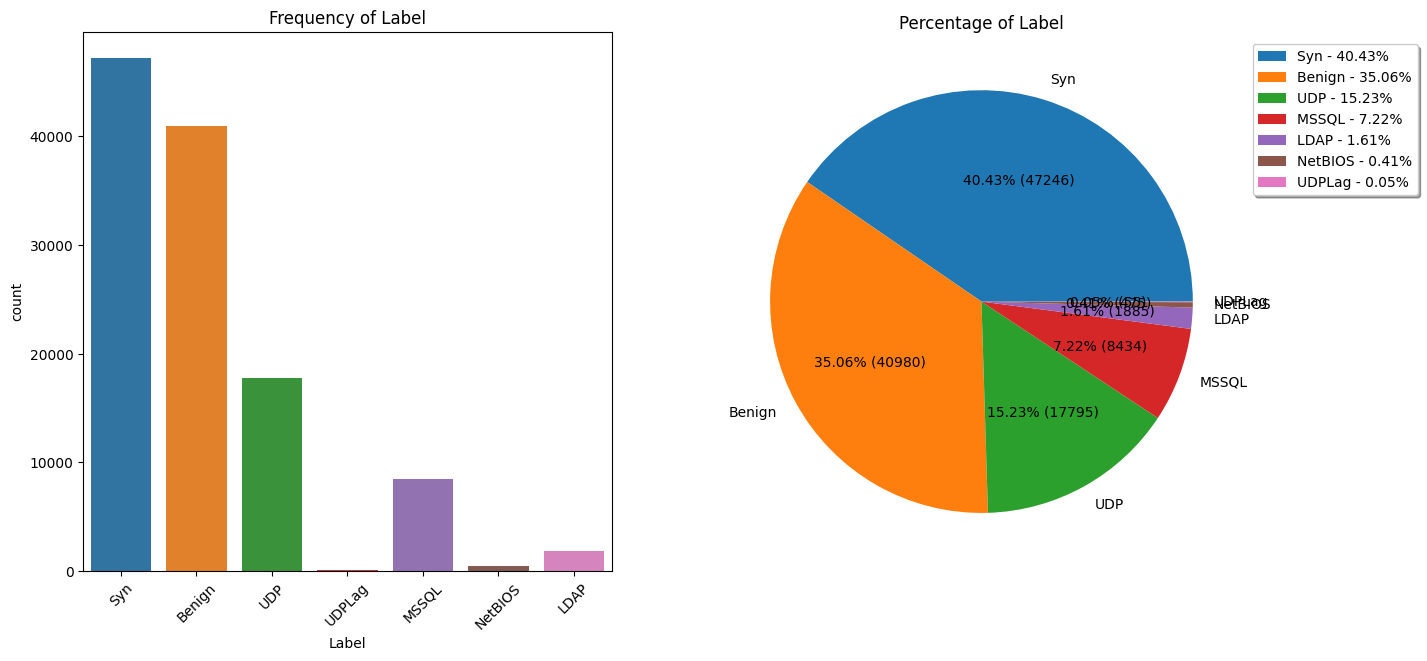

          Protocol      Ratio
Protocol                     
6            74330  63.600582
17           41807  35.772226
0              733   0.627193




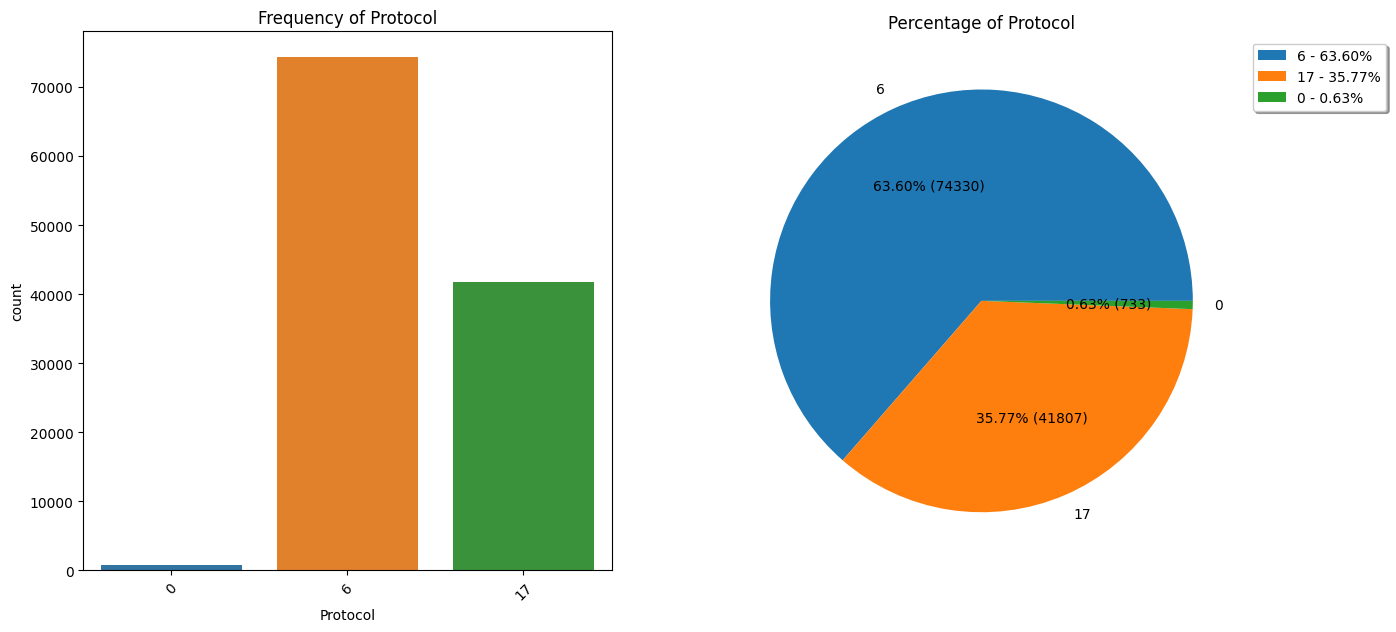

               Fwd PSH Flags      Ratio
Fwd PSH Flags                          
0                     111549  95.447078
1                       5321   4.552922




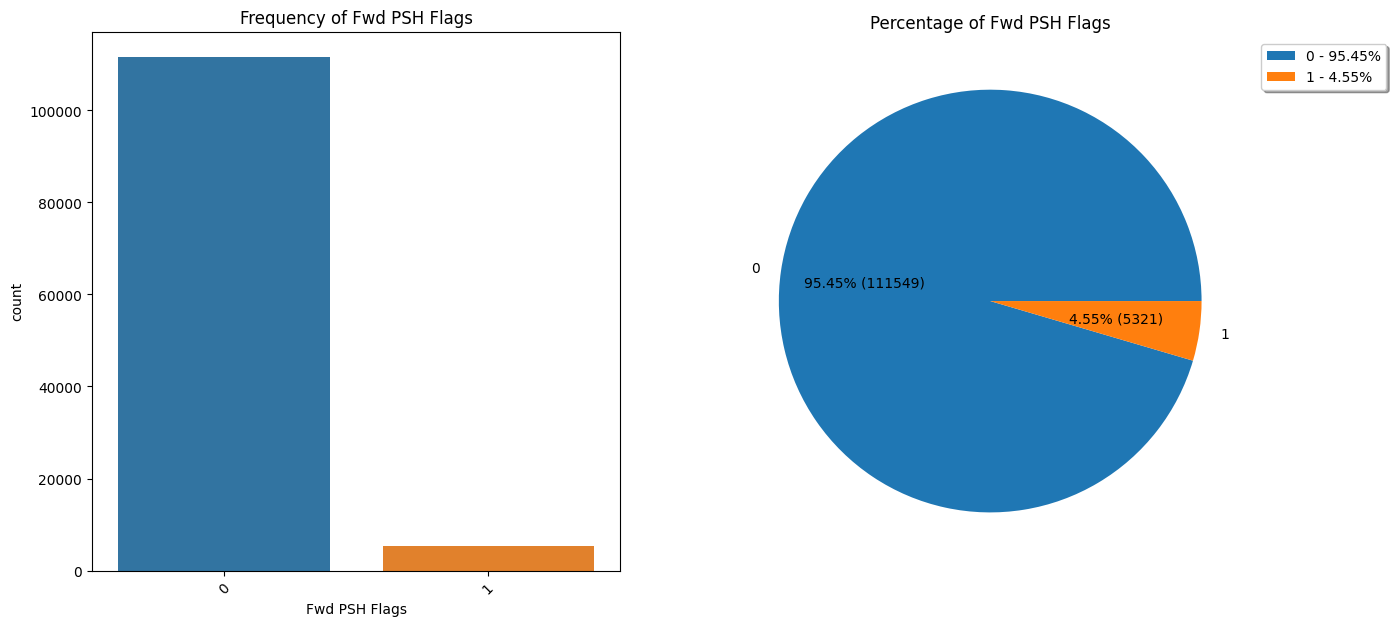

               Bwd PSH Flags  Ratio
Bwd PSH Flags                      
0                     116870  100.0




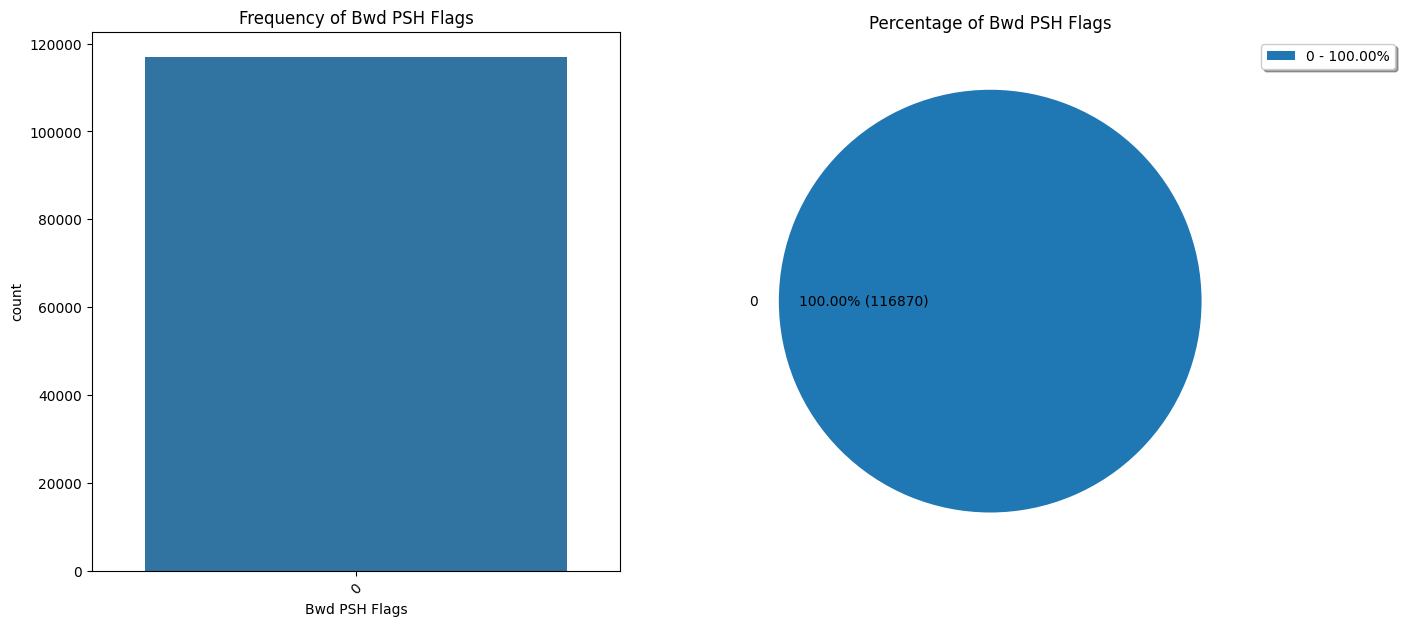

               Fwd URG Flags  Ratio
Fwd URG Flags                      
0                     116870  100.0




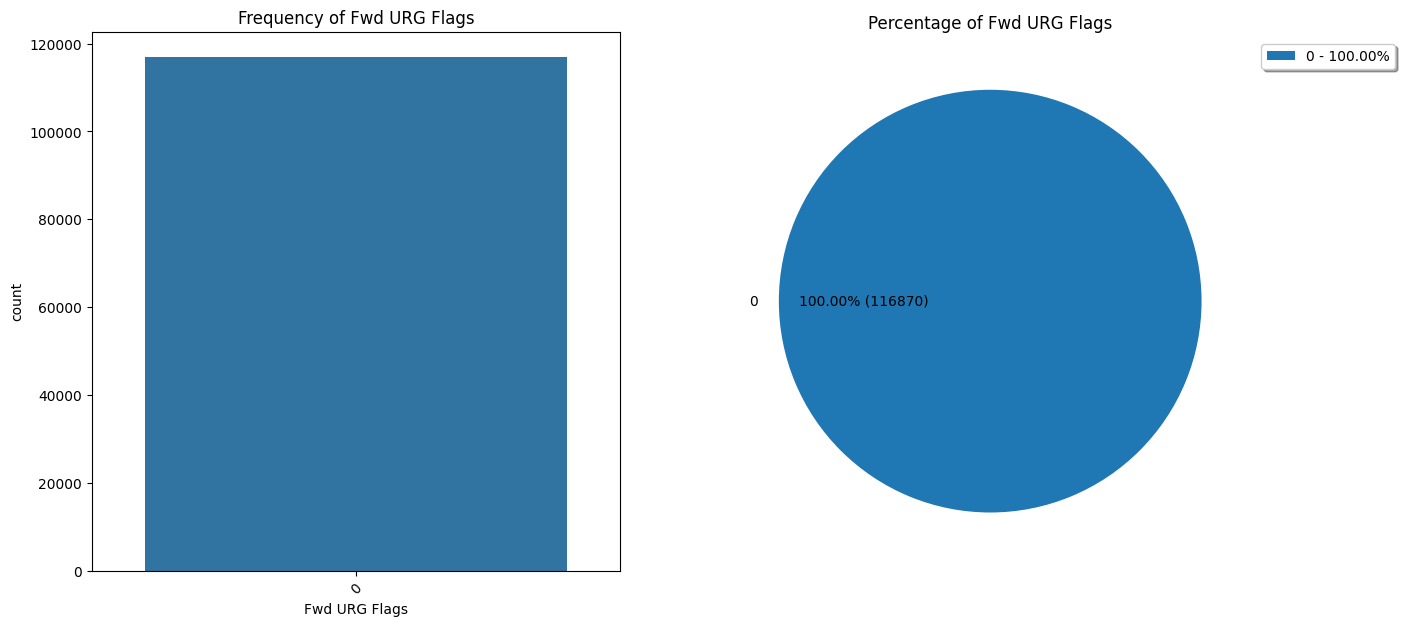

               Bwd URG Flags  Ratio
Bwd URG Flags                      
0                     116870  100.0




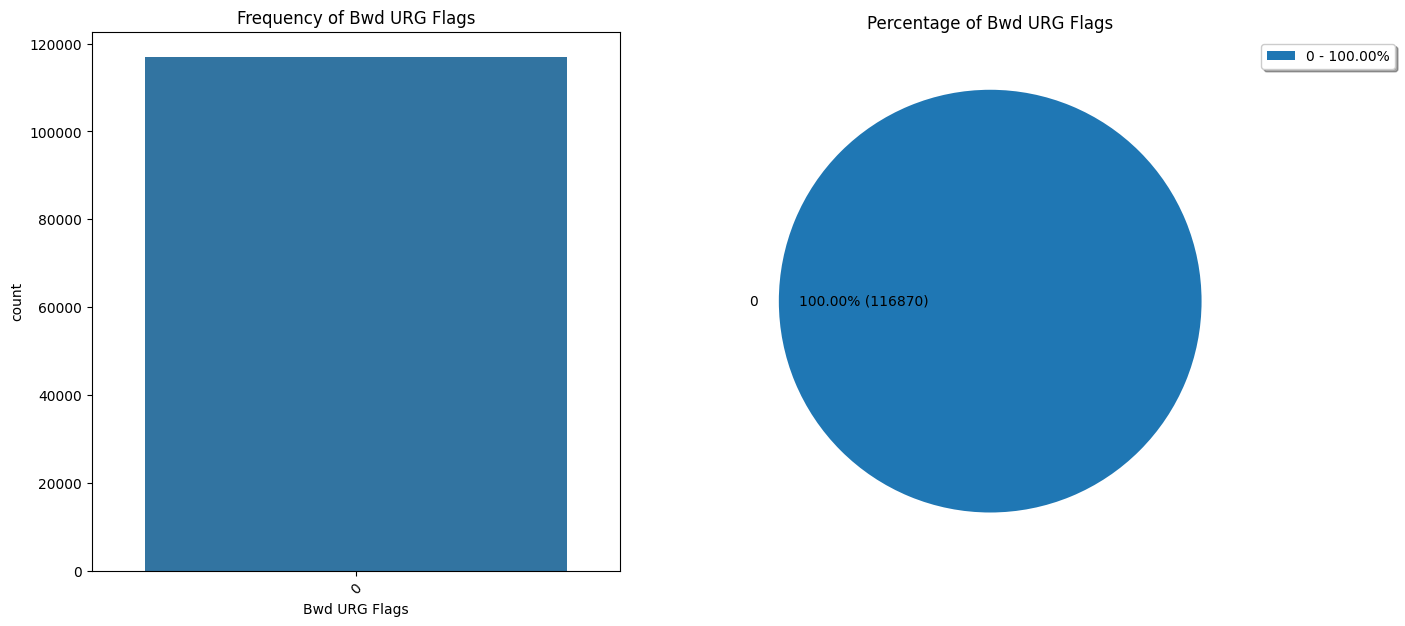

                FIN Flag Count  Ratio
FIN Flag Count                       
0                       116870  100.0




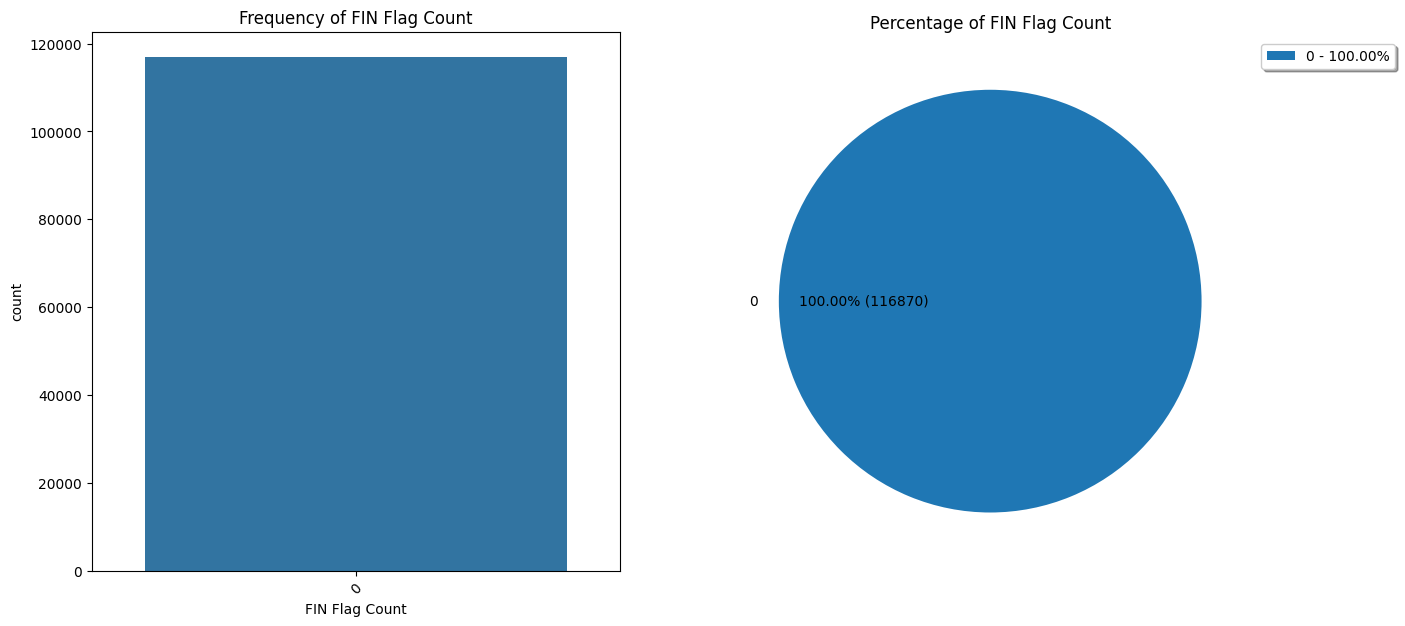

                SYN Flag Count      Ratio
SYN Flag Count                           
0                       116773  99.917002
1                           97   0.082998




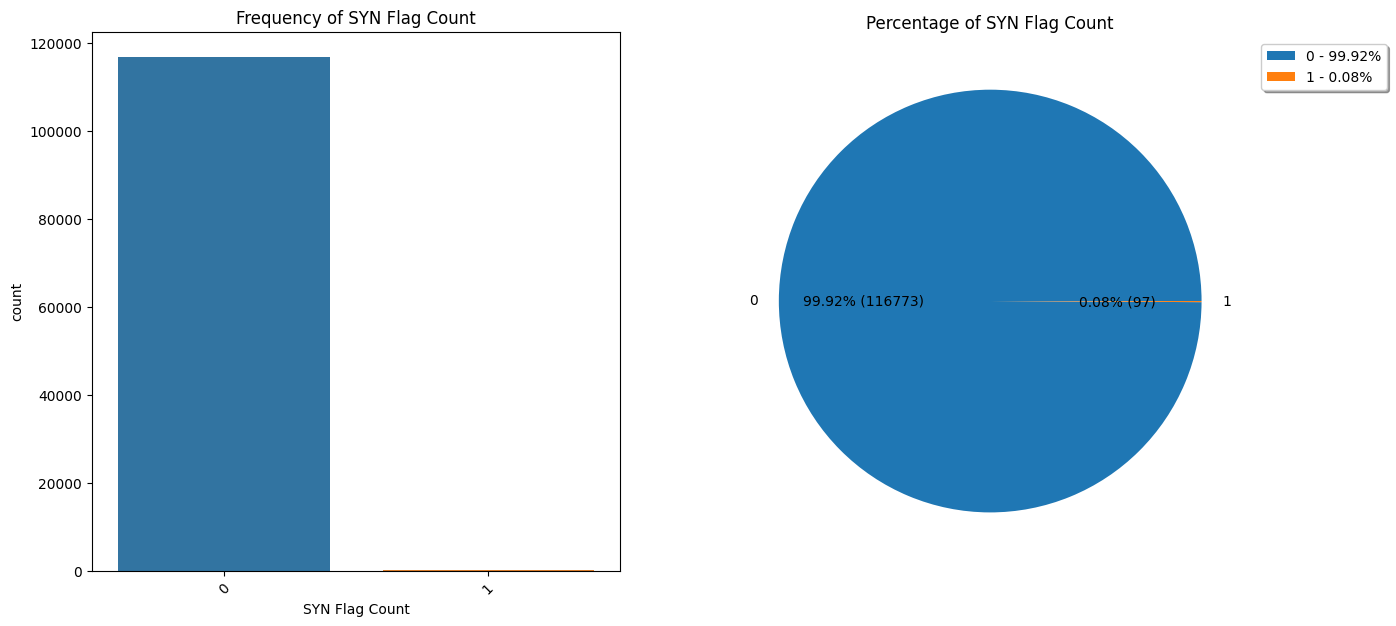

                RST Flag Count      Ratio
RST Flag Count                           
0                       111549  95.447078
1                         5321   4.552922




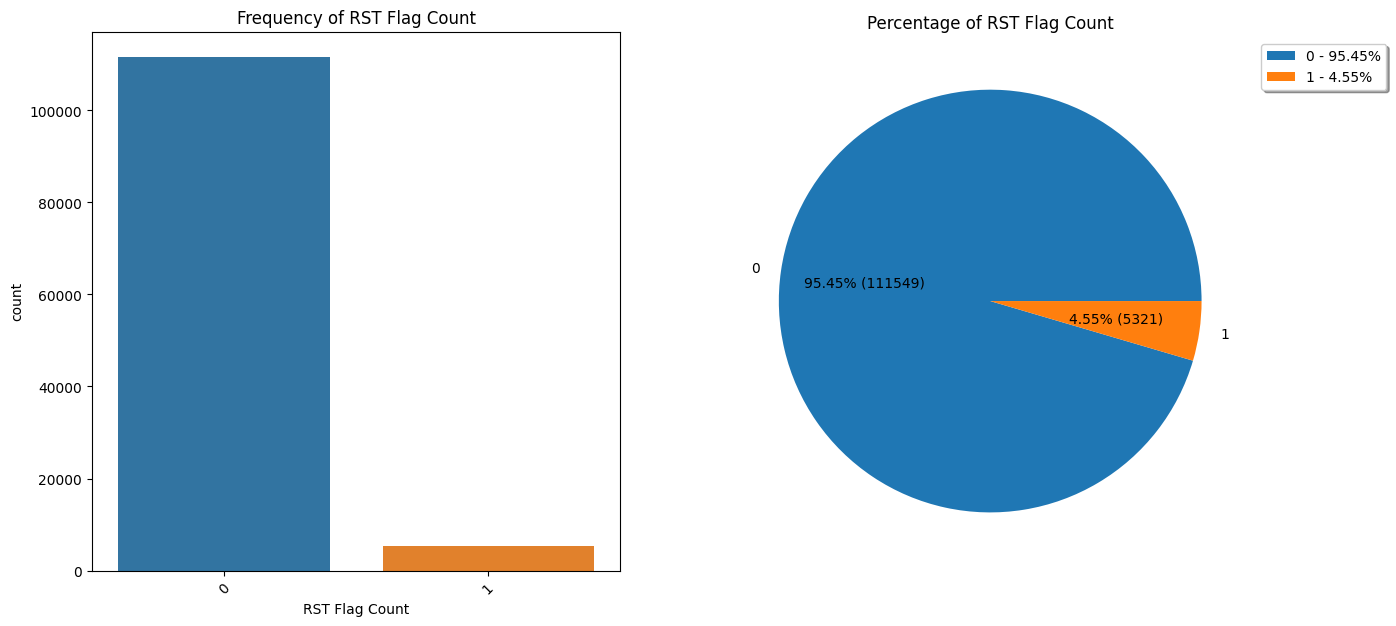

                PSH Flag Count  Ratio
PSH Flag Count                       
0                       116870  100.0




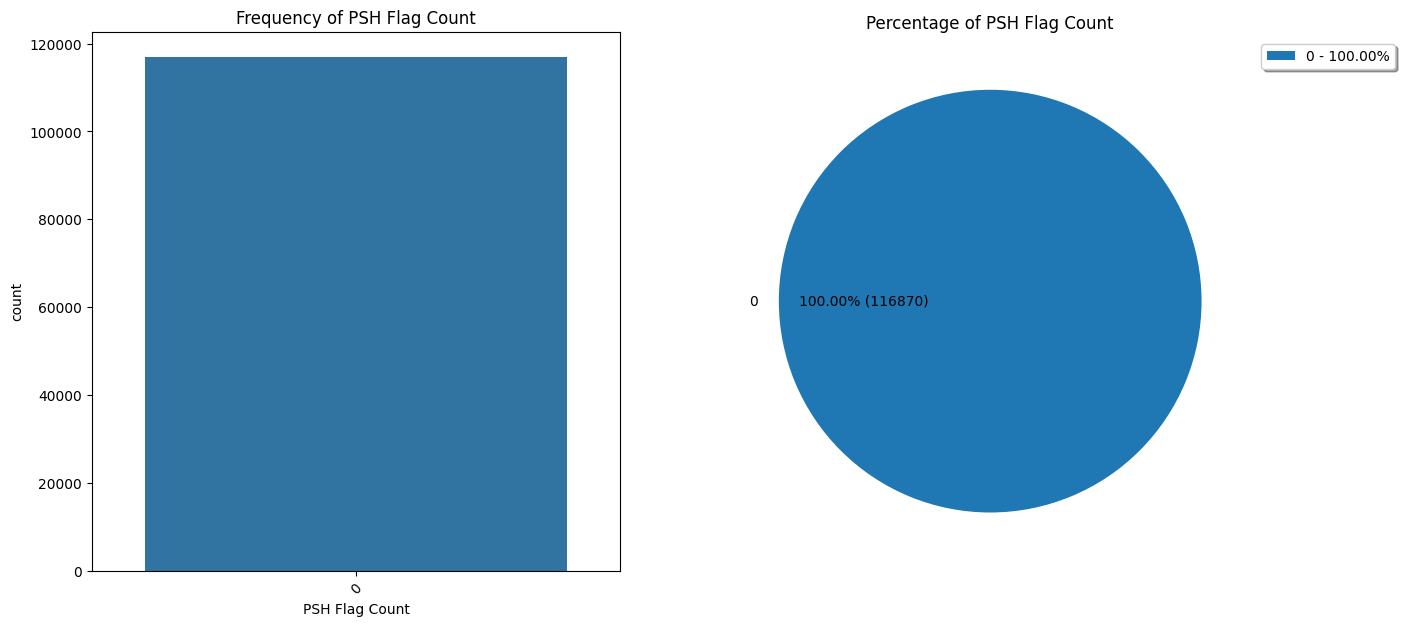

                ACK Flag Count      Ratio
ACK Flag Count                           
0                        60525  51.788312
1                        56345  48.211688




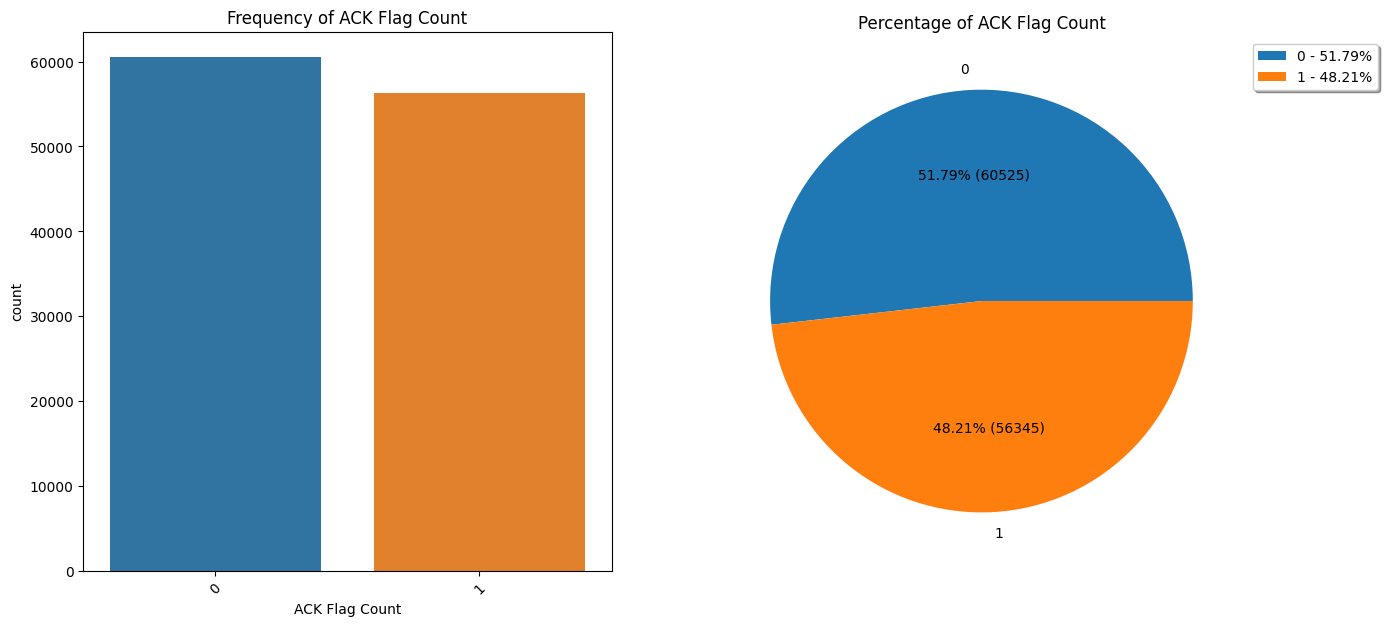

                URG Flag Count      Ratio
URG Flag Count                           
0                        98885  84.611106
1                        17985  15.388894




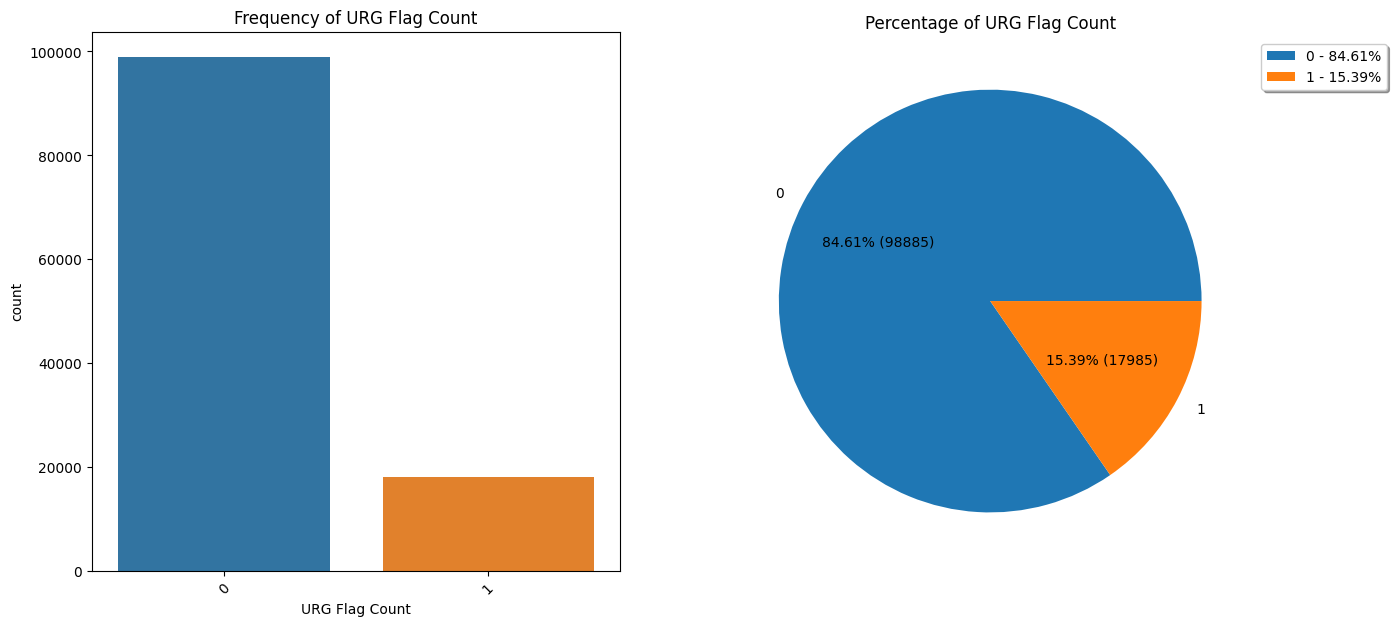

                CWE Flag Count      Ratio
CWE Flag Count                           
0                       107769  92.212715
1                         9101   7.787285




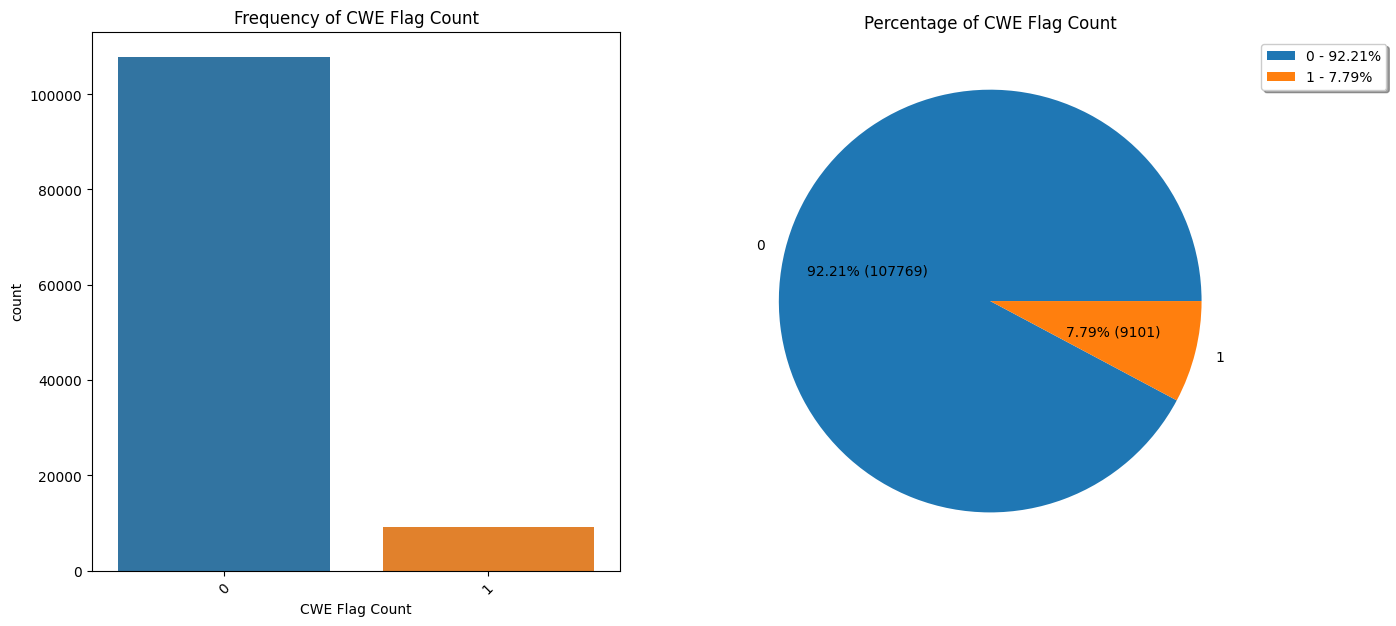

                ECE Flag Count  Ratio
ECE Flag Count                       
0                       116870  100.0




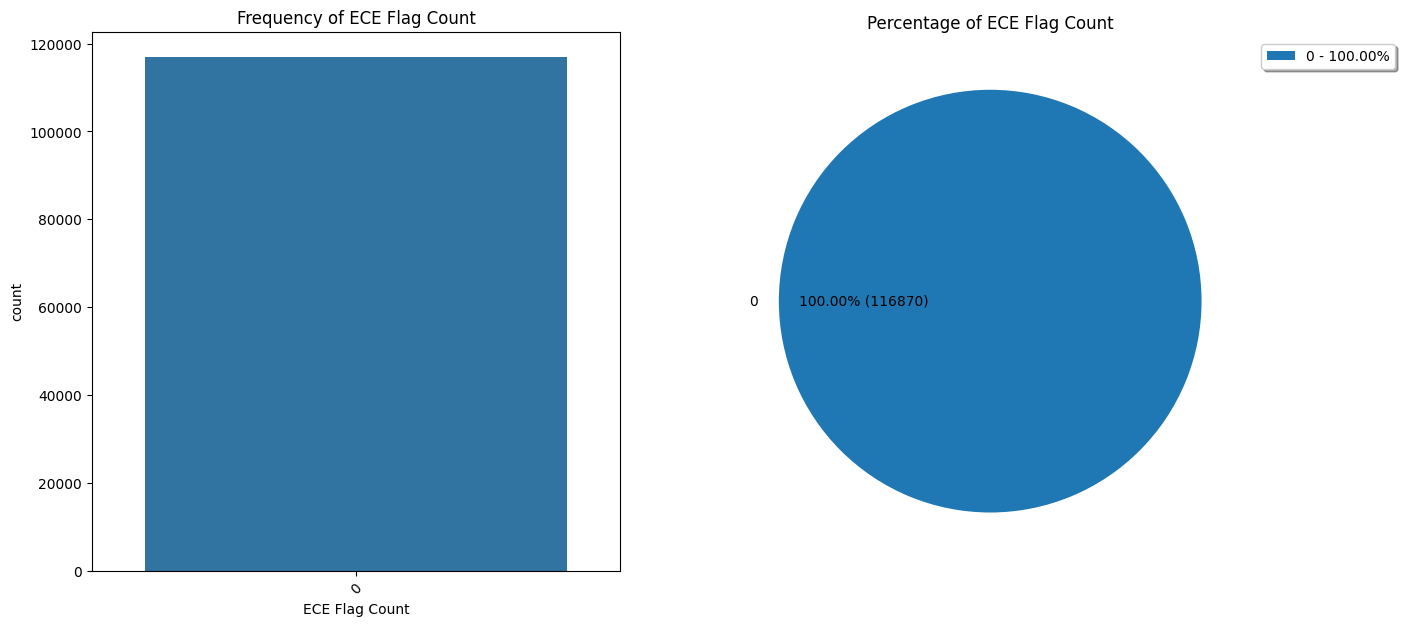

                    Fwd Avg Bytes/Bulk  Ratio
Fwd Avg Bytes/Bulk                           
0                               116870  100.0




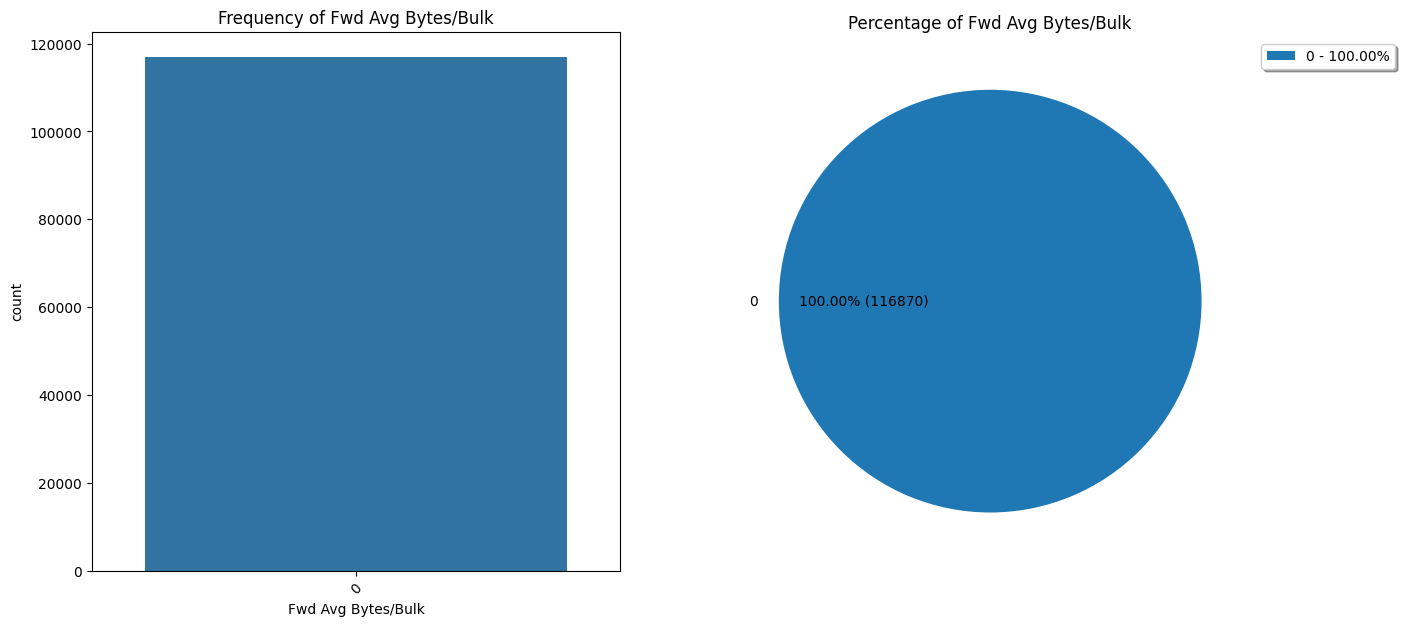

                      Fwd Avg Packets/Bulk  Ratio
Fwd Avg Packets/Bulk                             
0                                   116870  100.0




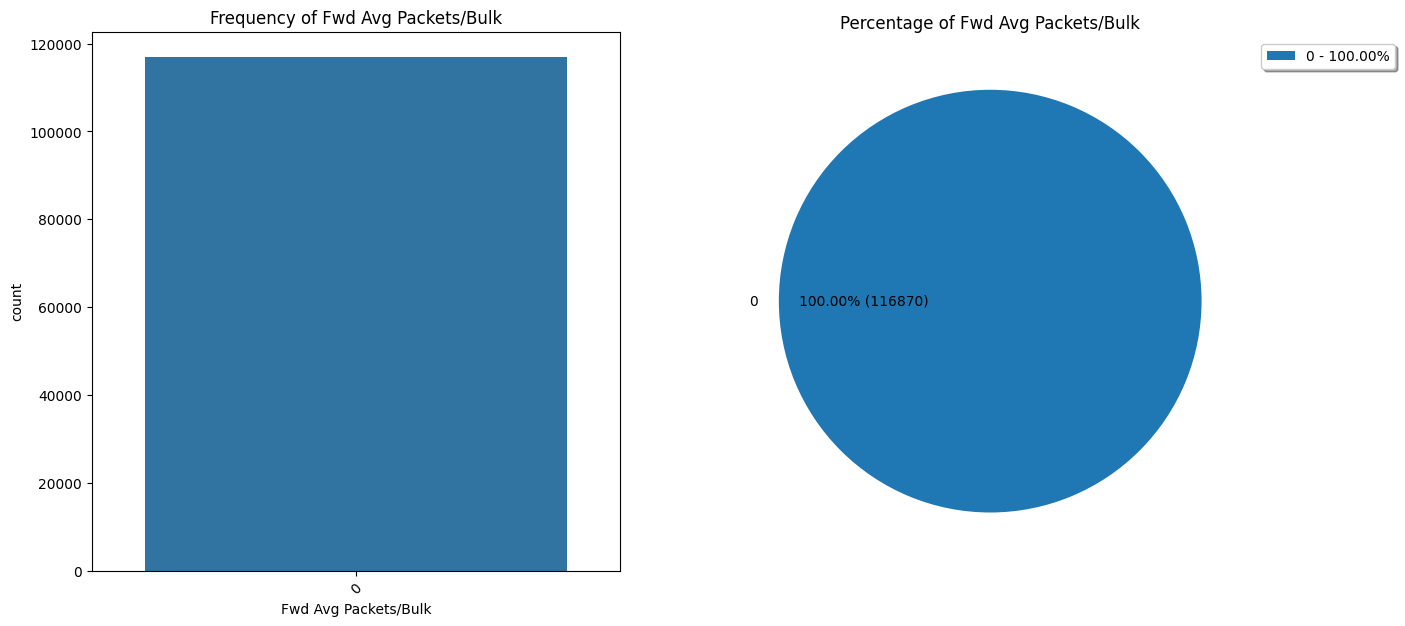

                   Fwd Avg Bulk Rate  Ratio
Fwd Avg Bulk Rate                          
0                             116870  100.0




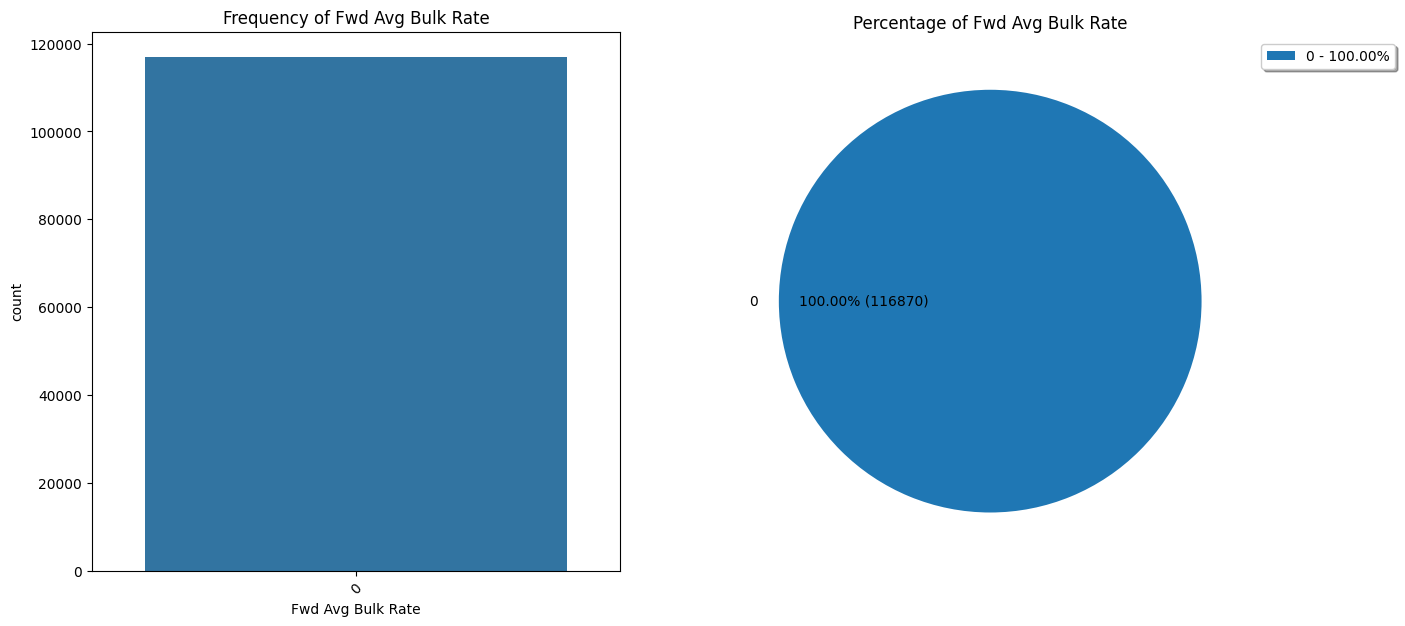

                    Bwd Avg Bytes/Bulk  Ratio
Bwd Avg Bytes/Bulk                           
0                               116870  100.0




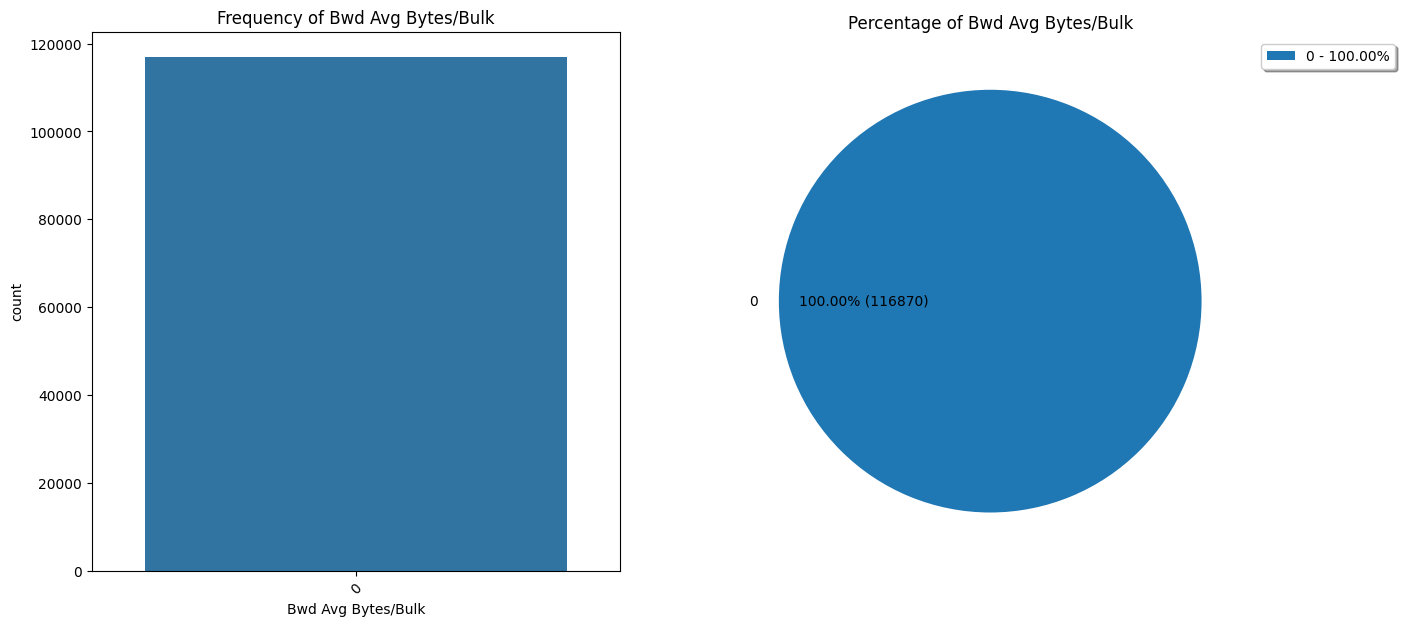

                      Bwd Avg Packets/Bulk  Ratio
Bwd Avg Packets/Bulk                             
0                                   116870  100.0




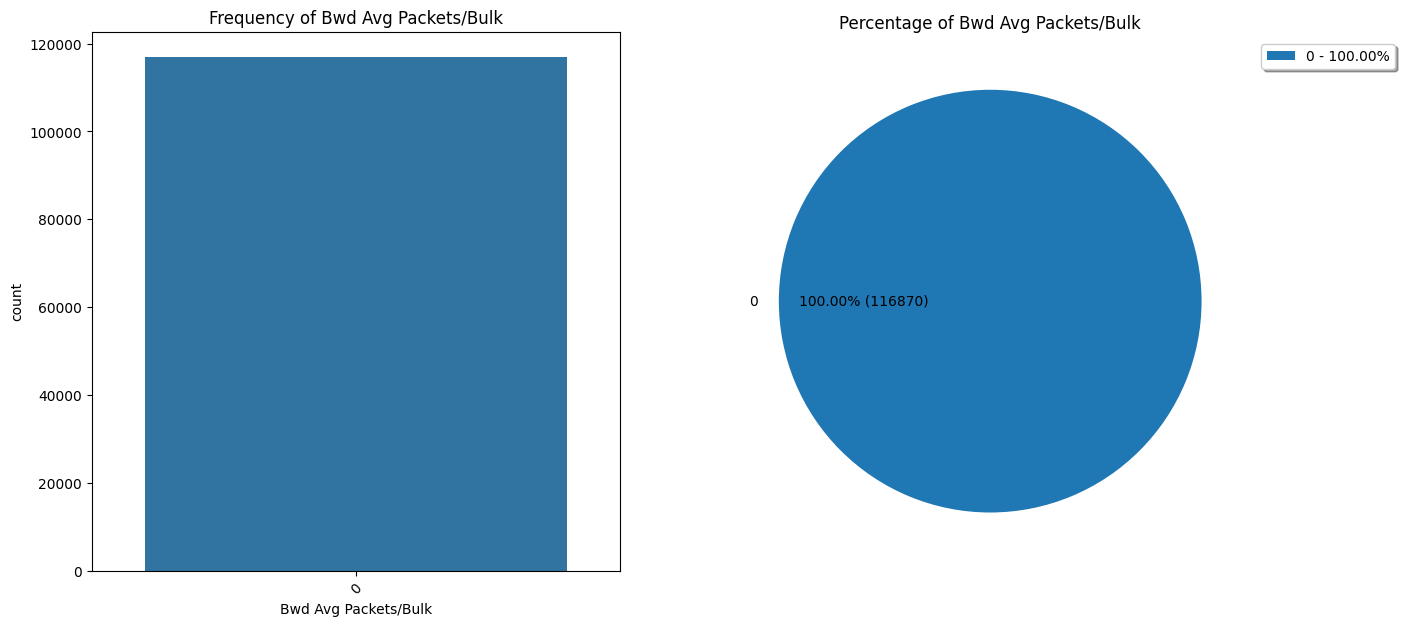

                   Bwd Avg Bulk Rate  Ratio
Bwd Avg Bulk Rate                          
0                             116870  100.0




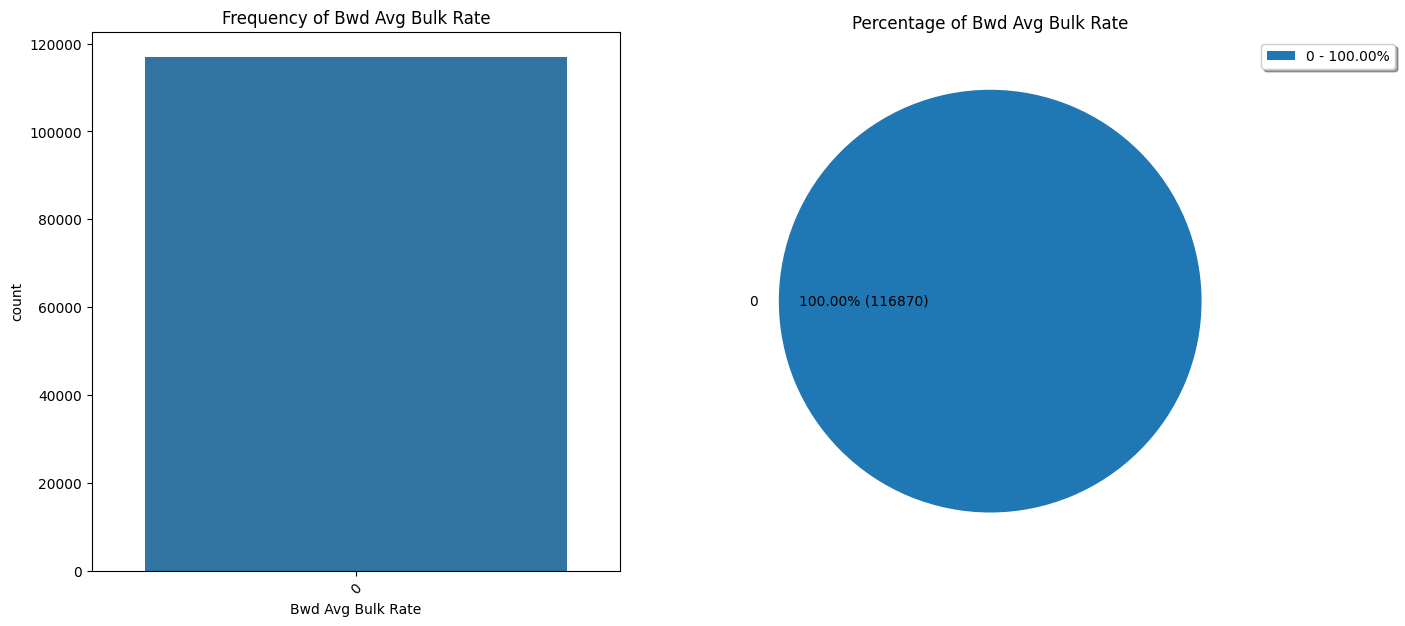

In [21]:
def cat_summary(data, col, plot=False):
    print(pd.DataFrame({col: data[col].value_counts(), "Ratio": data[col].value_counts() / len(data) * 100}))
    print("\n")

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(15, 7))
        plt.subplot(1, 2, 1)
        sns.countplot(x=col, data=data)
        plt.xticks(rotation=45)
        plt.title(f"Frequency of {col}")

        plt.subplot(1, 2, 2)
        values = data[col].value_counts()
        plt.pie(x=values, labels=values.index, autopct=lambda x: "{:.2f}% ({:.0f})".format(x, x/100 * sum(values)))
        plt.legend(labels=['{} - {:.2f}%'.format(index, value / sum(values) * 100) for index, value in zip(values.index, values)],
                   loc="upper left",
                   bbox_to_anchor=(1, 1),
                   fancybox=True,
                   shadow=True,
                   ncol=1)
        plt.title(f"Percentage of {col}")
        plt.show(block=True)

for col in cat_cols:
    cat_summary(train_df, col, True)

# Numberical Columns

In [22]:
# Distribution Plots for Numerical Columns
def my_histplot(data, col, ax):
    sns.histplot(x=col, data=data, kde=True, ax=ax)
    ax.set_title(f"Histogram of {col}")

def my_distplot(data, col, ax):
    sns.distplot(data[col], ax=ax)
    ax.set_title(f"Distribution of {col}")

def my_kdeplot(data, col, ax):
    sns.kdeplot(x=col, data=data, ax=ax)
    ax.set_title(f"KDE Plot of {col}")

# Relational Plots for Numerical Columns
def my_scatterplot(data, col, ax):
    sns.scatterplot(x=col, data=data, ax=ax)
    ax.set_title(f"Scatter Plot of {col}")

def my_lineplot(data, col, ax):
    sns.lineplot(x=col, data=data, ax=ax)
    ax.set_title(f"Line Plot of {col}")

# Categorical Plots for Categorical Columns
def my_pie_chart(data, col, ax):
    values = data[col].value_counts()
    ax.pie(x=values, labels=values.index, autopct=lambda x: "{:.2f}% ({:.0f})".format(x, x/100 * sum(values)))
    ax.legend(labels=['{} - {:.2f}%'.format(index, value / sum(values) * 100) for index, value in zip(values.index, values)],
              loc="upper left",
              bbox_to_anchor=(1, 1),
              fancybox=True,
              shadow=True,
              ncol=1)
    ax.set_title(f"Pie Chart of {col}")

def my_countplot(data, col, ax):
    sns.countplot(x=col, data=data, ax=ax)
    ax.set_title(f"Count Plot of {col}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

def my_boxplot(data, col, ax):
    sns.boxplot(y=col, data=data, ax=ax)

def my_violinplot(data, col, ax):
    sns.violinplot(y=col, data=data, ax=ax)

def my_swarmplot(data, col, ax):
    sns.swarmplot(y=col, data=data, ax=ax)

# Matrix Plots for Numerical Columns
def my_headmap(data, size):
    if size: plt.figure(figsize=size)
    sns.heatmap(data.corr(), annot=True, fmt=".1f", cmap="Blues", annot_kws={"size": 12})
    plt.title("Correlation Matrix")
    plt.show()

def plot_charts_grid_single_feature(data, plot_func, size=(12, 4), n_col=1):
    if len(data.columns) == 0:
        return
    n_rows = (len(data.columns) + n_col - 1) // n_col
    fig, axes = plt.subplots(n_rows, n_col, figsize=(size[0]*n_col, size[1]*n_rows))
    if len(data.columns) == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, col in enumerate(data.columns):
        plot_func(data, col, axes[i])

    for j in range(i+1, n_rows*n_col):
        axes[j].axis("off")
    
    plt.tight_layout()
    plt.show()

In [23]:
# plot_charts_grid_single_feature(train_df[num_cols], my_histplot, size=(12, 4), n_col=2)

In [24]:
#plot_charts_grid_single_feature(train_df[num_cols], my_boxplot, size=(2, 4), n_col=6)

### Packet Size and Flow Duration Analysis

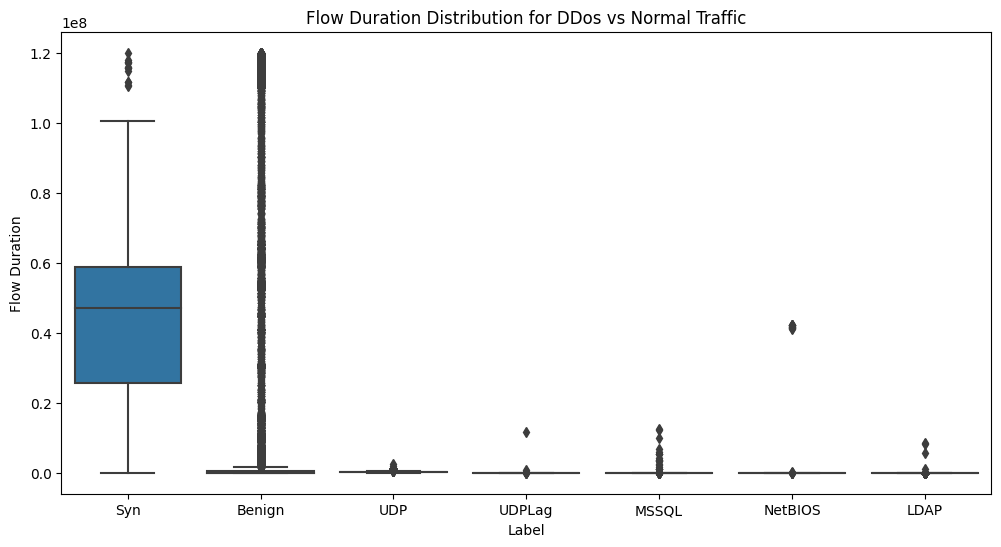

In [25]:
# Boxplot of Flow Duration by Attack Label
plt.figure(figsize=(12, 6))
sns.boxplot(x="Label", y="Flow Duration", data=train_df)
plt.title("Flow Duration Distribution for DDos vs Normal Traffic")
plt.show()

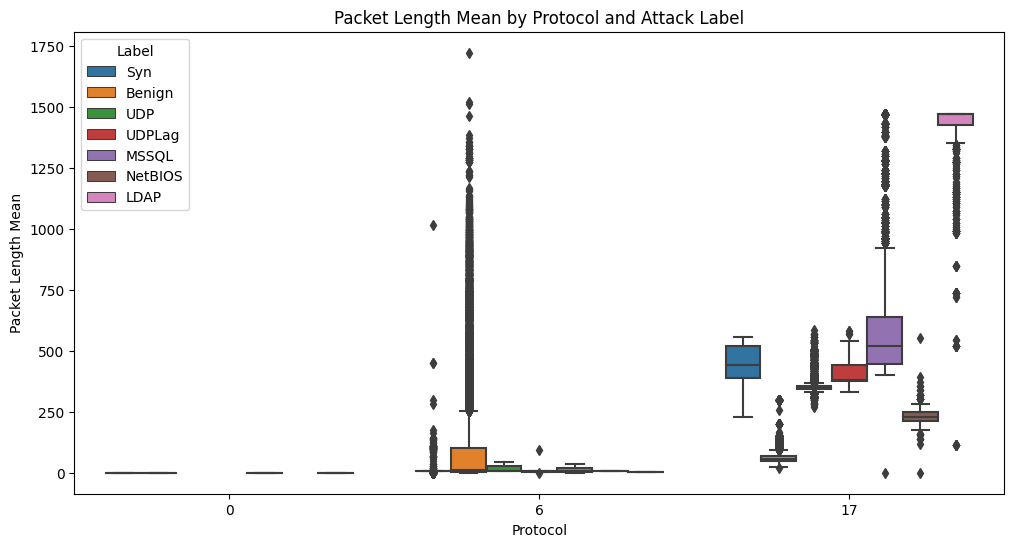

In [26]:
# Boxplot of Packet Length Mean by Protocol and Label
plt.figure(figsize=(12, 6))
sns.boxplot(x="Protocol", y="Packet Length Mean", hue="Label", data=train_df)
plt.title("Packet Length Mean by Protocol and Attack Label")
plt.show()

### Packet Flags and Attack Patterns

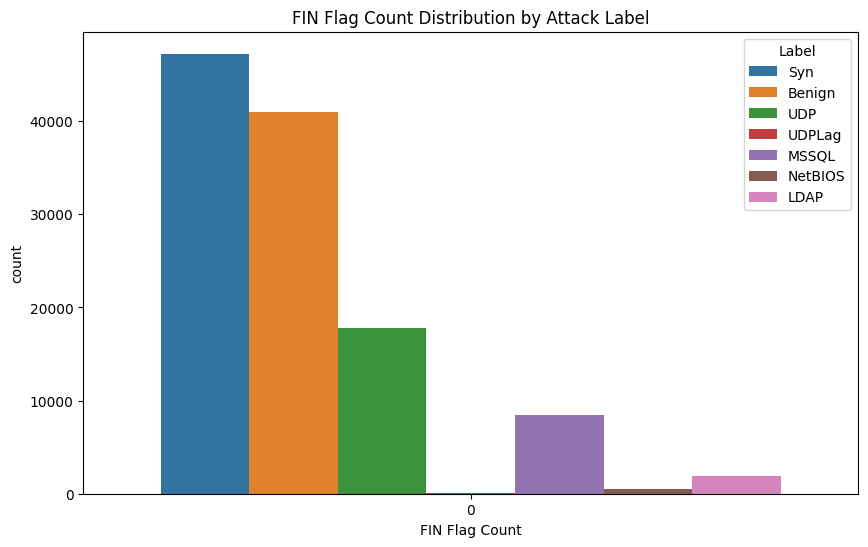

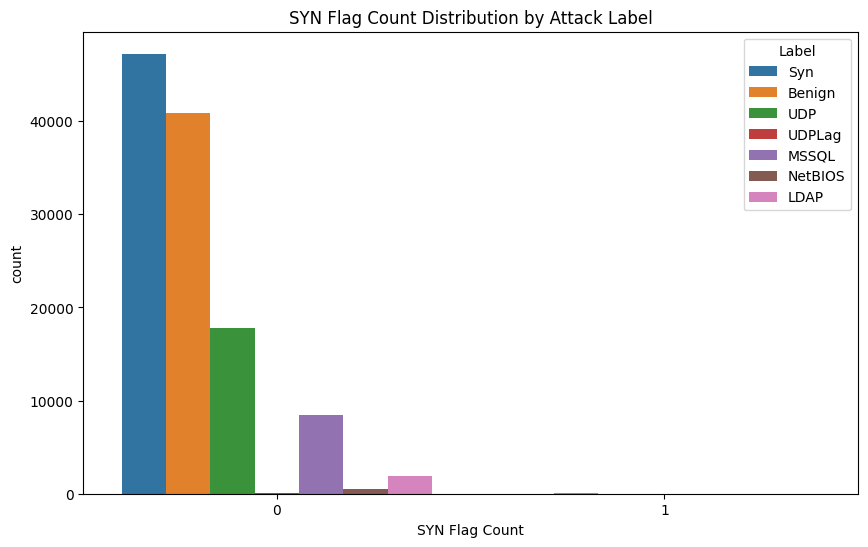

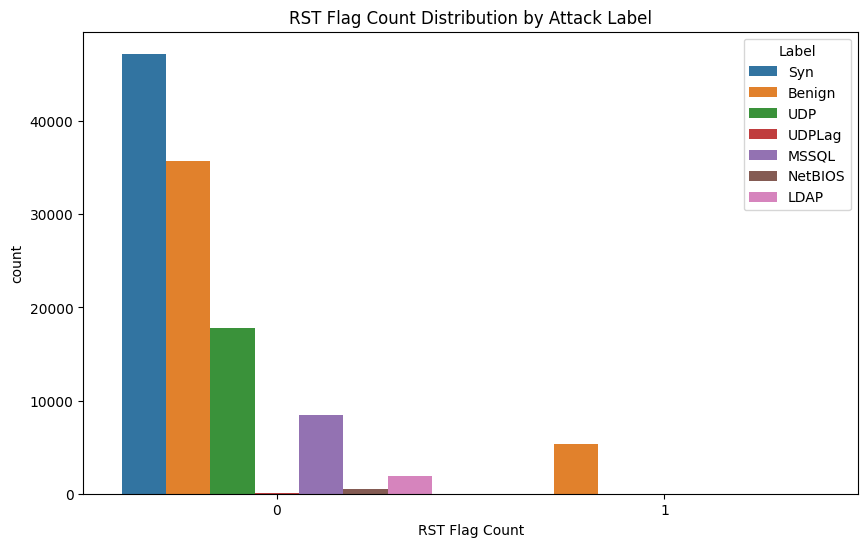

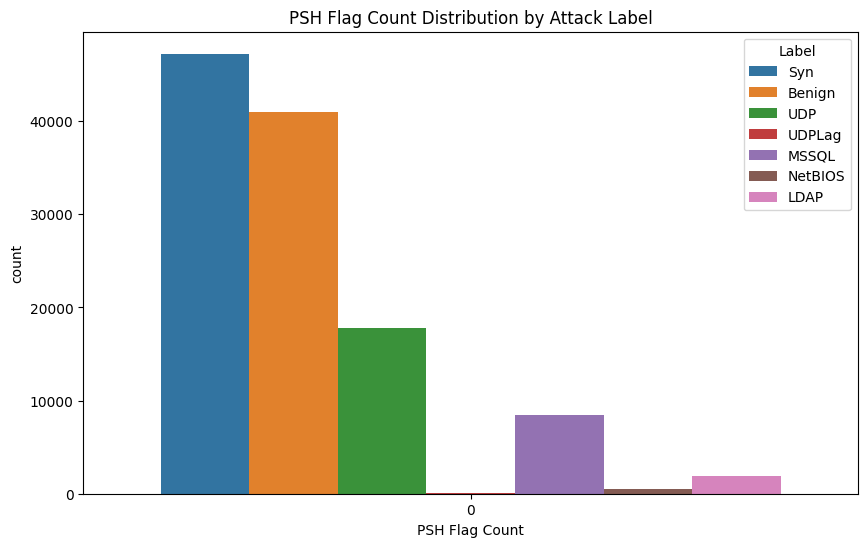

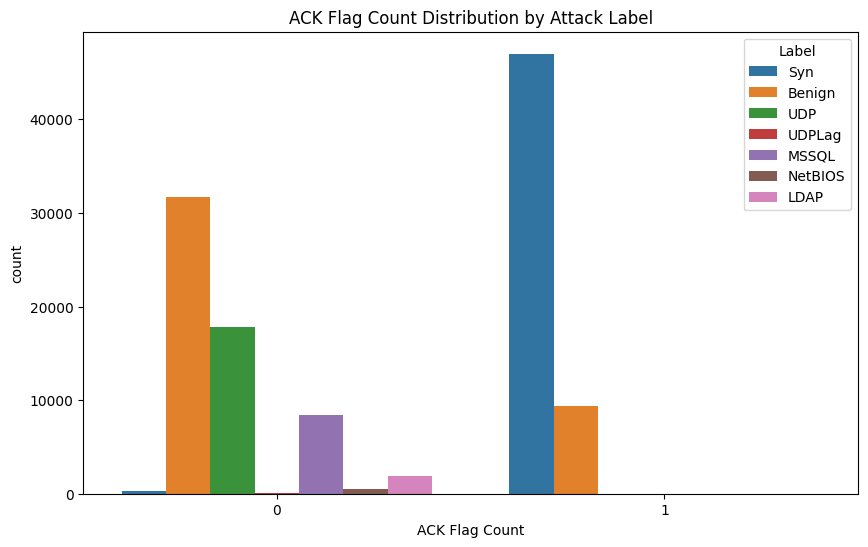

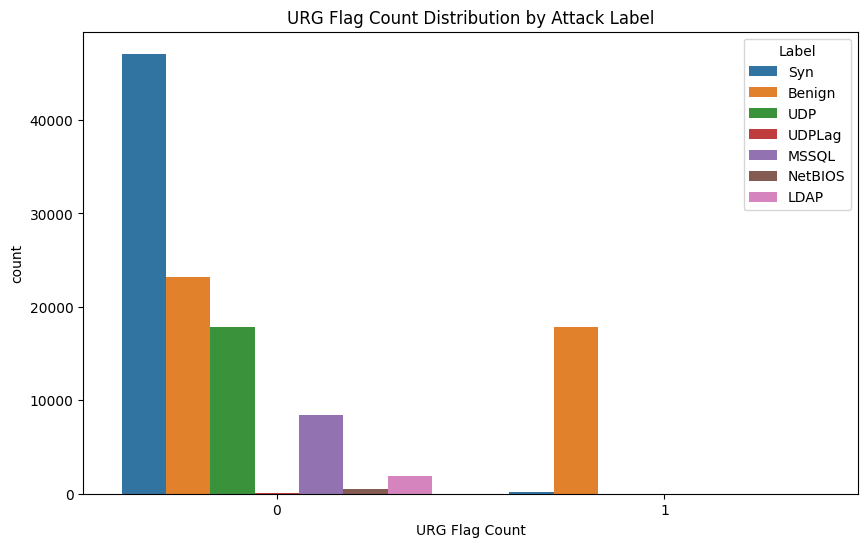

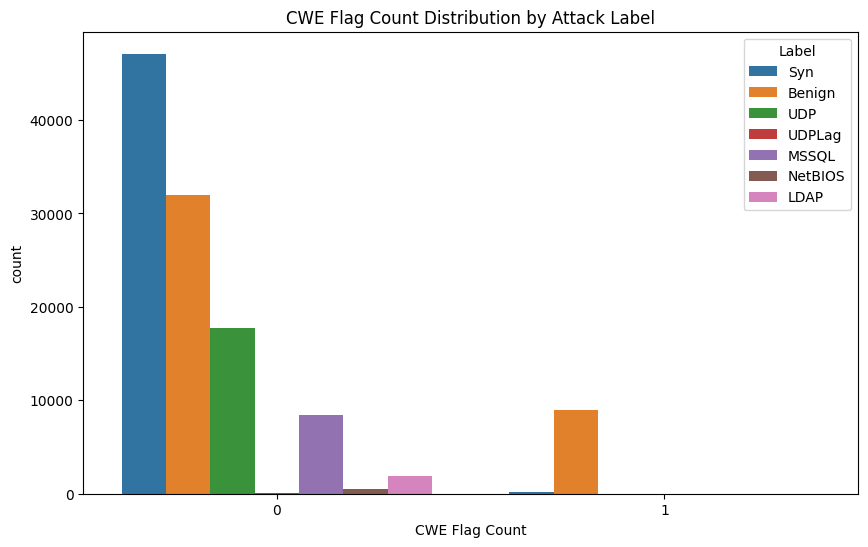

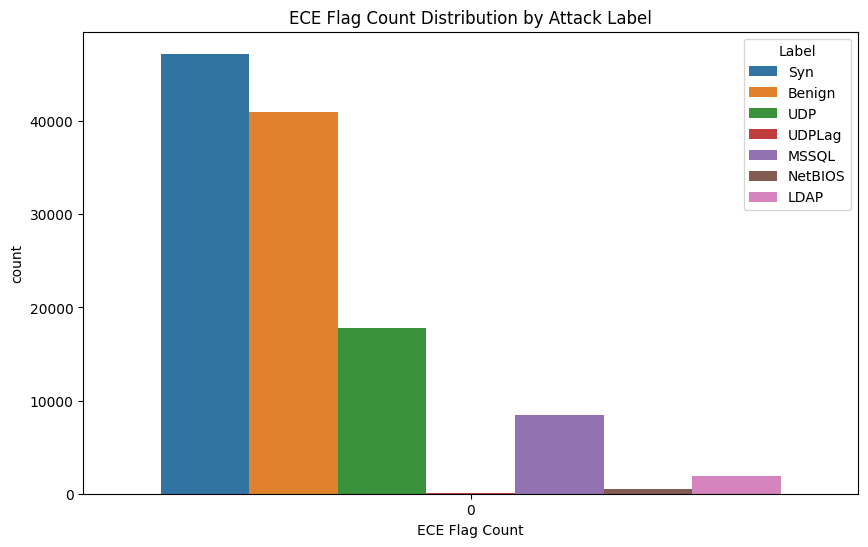

In [27]:
# Counting the number of occurrences of each flag in attack vs normal traffic
flag_cols = [col for col in train_df.columns if "Flag " in col]

for flag in flag_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=flag, hue="Label", data=train_df)
    plt.title(f"{flag} Distribution by Attack Label")
    plt.show()


### Requests from Different Protocols

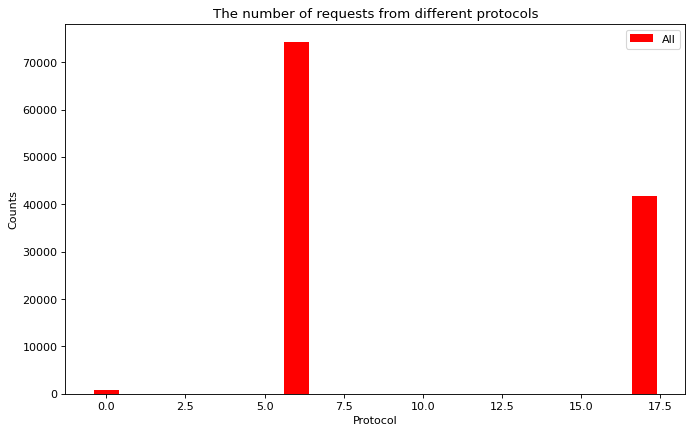

In [28]:
# Protocol distribution
plt.figure(figsize=(10, 6), dpi=80)
plt.bar(list(dict(train_df["Protocol"].value_counts()).keys()), dict(train_df["Protocol"].value_counts()).values(), color='r')

plt.xlabel("Protocol")
plt.ylabel("Counts")
plt.legend(["All"])
plt.title("The number of requests from different protocols")
plt.show()

### Correlation Matrix

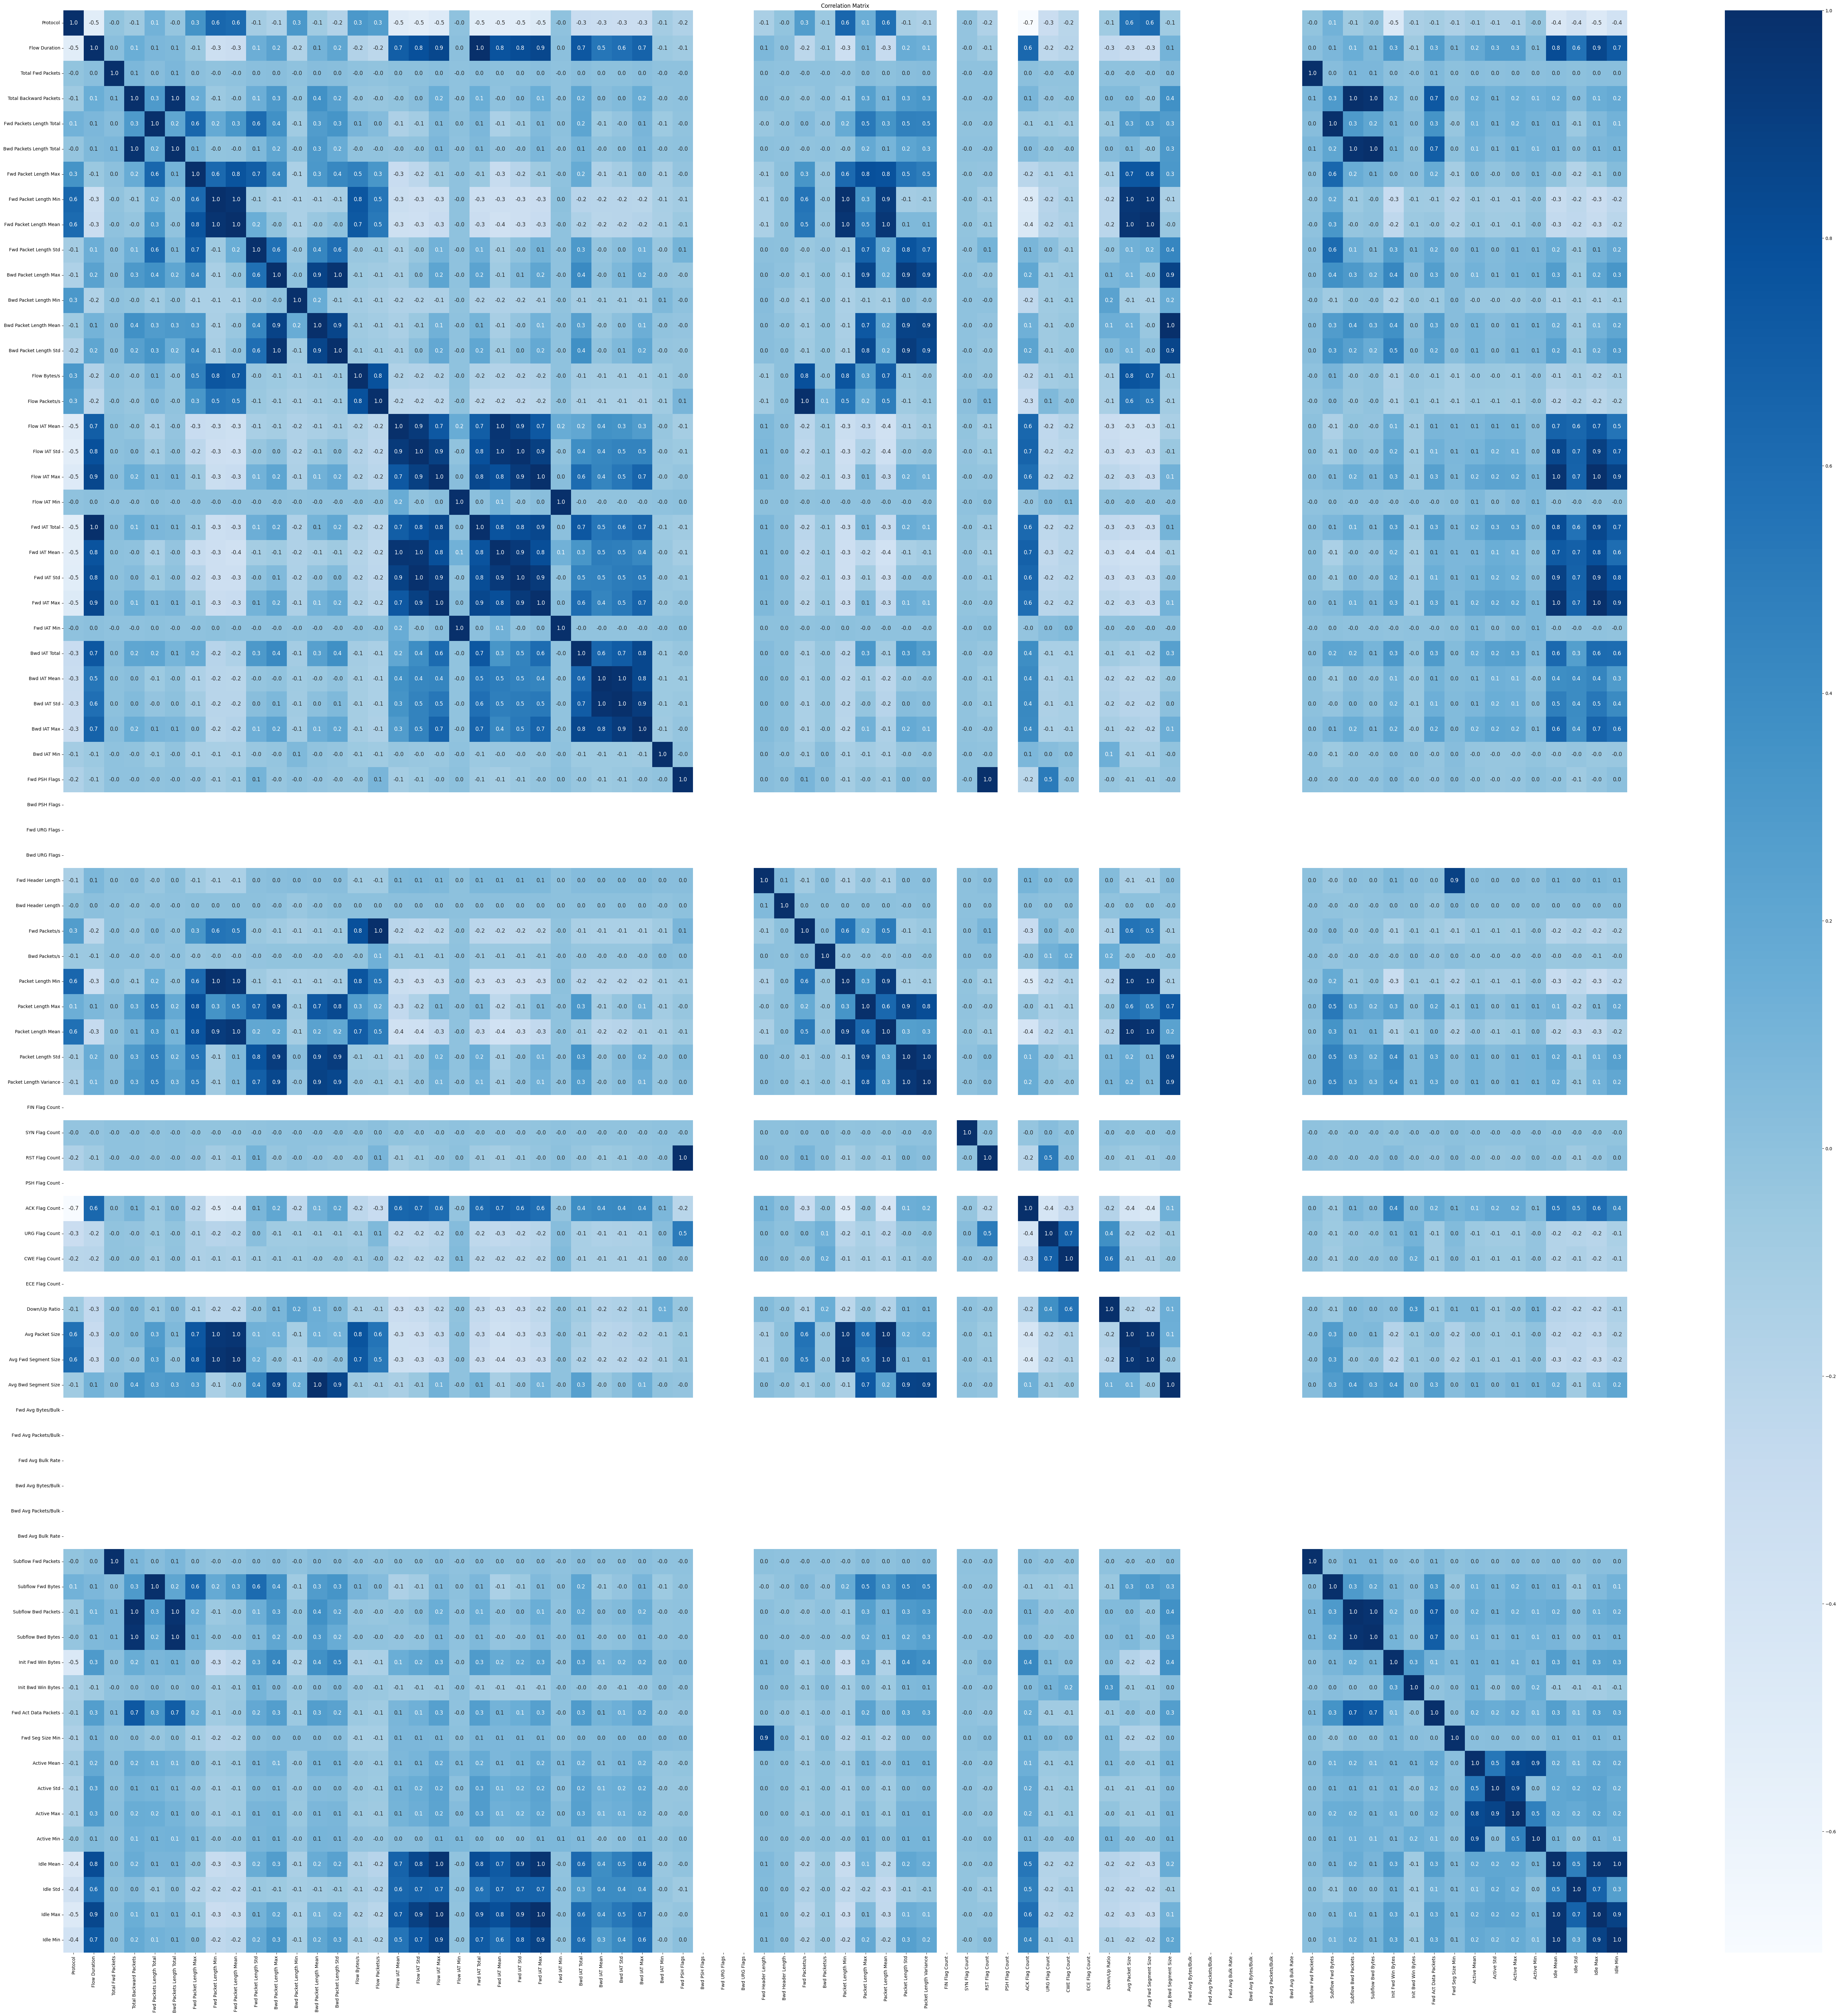

In [29]:
# Correlation heatmap
n_numeric_cols = len(train_df.select_dtypes(include=[np.number]).columns)
my_headmap(train_df.select_dtypes(include=[np.number]), size=(n_numeric_cols+1, n_numeric_cols+1))

## Future Engineering

### Feature Selection

In [30]:
# Features with a single unique value
single_val_cols = [col for col in train_df.columns if train_df[col].nunique() == 1]
print("Columns with single value:", single_val_cols)

Columns with single value: ['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'FIN Flag Count', 'PSH Flag Count', 'ECE Flag Count', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


In [31]:
# Remove columns with a single unique value
train_df.drop(single_val_cols, axis=1, inplace = True)
test_df.drop(single_val_cols, axis=1, inplace = True)

In [32]:
# Shape of the dataset after removing columns with a single unique value
print("Dataset shape after removing single value columns:", train_df.shape, test_df.shape)

Dataset shape after removing single value columns: (116870, 66) (38922, 66)


In [33]:
# Select only numeric columns
numerical_df = train_df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numerical_df.corr().abs()

# Generate a boolean mask for the upper triangle
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

# Select the upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(mask)

# Find the columns with correlation of 0.8 or higher
high_corr_cols = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.8)]

# Display the number of highly correlated columns and their names
print(f"Total number of highly correlated columns: {len(high_corr_cols)}")
print("Highly correlated columns are:", high_corr_cols)

Total number of highly correlated columns: 33
Highly correlated columns are: ['Bwd Packets Length Total', 'Fwd Packet Length Mean', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Max', 'Fwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'RST Flag Count', 'Avg Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Fwd Seg Size Min', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Max', 'Idle Min']


In [34]:
# Remove highly correlated columns from the dataset
train_df.drop(high_corr_cols, axis=1, inplace=True)
test_df.drop(high_corr_cols, axis=1, inplace=True)

In [35]:
# Shape of the dataset after removing highly correlated columns
print("Dataset shape after removing highly correlated columns:", train_df.shape, test_df.shape)

Dataset shape after removing highly correlated columns: (116870, 33) (38922, 33)


### Train Test Validation Split

In [36]:
# Split the data into training, validation, and testing sets
X_train, X_val, y_train, y_val = train_test_split(train_df.drop("Label", axis=1), train_df["Label"], test_size=0.2, random_state=42)
X_test, y_test = test_df.drop("Label", axis=1), test_df["Label"]


In [37]:
print(X_train.shape, X_val.shape, X_test.shape)

(93496, 32) (23374, 32) (38922, 32)


In [38]:
print(y_train.shape, y_val.shape, y_test.shape)


(93496,) (23374,) (38922,)


### Feature Encoding

In [39]:
# Encode the target variable
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

# Label mapping for the target variable
label_map = {index: Label for index, Label in enumerate(le.classes_)}

In [40]:
print("Label mapping:", label_map)


Label mapping: {0: 'Benign', 1: 'LDAP', 2: 'MSSQL', 3: 'NetBIOS', 4: 'Syn', 5: 'UDP', 6: 'UDPLag'}


### Feature Scaling

In [41]:
# Feature Scaling using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)



In [42]:
# Convert target to one-hot encoding for neural networks
num_classes = len(le.classes_)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [43]:
# Reshape data for CNN and LSTM (samples, time steps, features)
# For CNN and LSTM, we need 3D data: [samples, time steps, features]
# Since this is tabular data, we'll use 1 time step
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_val_reshaped = X_val_scaled.reshape(X_val_scaled.shape[0], 1, X_val_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

In [44]:
# CNN Model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=1, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        Conv1D(128, kernel_size=1, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [45]:
# LSTM Model
def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(128),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [46]:
def create_transformer_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = inputs
    
    # Transformer Block
    attention_output = MultiHeadAttention(num_heads=4, key_dim=16, dropout=0.2)(x, x)
    x = LayerNormalization(epsilon=1e-6)(attention_output + x)
    
    # Feed-forward network
    x_ff = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x_ff = Dropout(0.3)(x_ff)
    
    # Ensure the dimensions of x and x_ff match before addition
    x_ff = Dense(x.shape[-1])(x_ff)  # Resize x_ff to match the shape of x
    
    # LayerNormalization after addition
    x = LayerNormalization(epsilon=1e-6)(x + x_ff)
    
    # Global average pooling
    x = GlobalAveragePooling1D()(x)
    
    # Fully connected layers
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.4)(x)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [47]:
# Train CNN
print("\n--- Training CNN Model ---")
# Định nghĩa callbacks trước khi sử dụng
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
callbacks = [early_stopping, reduce_lr]

cnn_model = create_cnn_model((1, X_train.shape[1]), num_classes)
cnn_model.summary()
cnn_history = cnn_model.fit(
    X_train_reshaped, y_train_cat,
    epochs=50,
    batch_size=64,
    validation_data=(X_val_reshaped, y_val_cat),
    callbacks=callbacks,
    verbose=1
)


--- Training CNN Model ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1, 64)               │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1, 128)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,615 (111.78 KB)

 Trainable params: 28,231 (110.28 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9221 - loss: 0.3648 - val_accuracy: 0.9833 - val_loss: 0.0951 - learning_rate: 0.0010
Epoch 2/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9778 - loss: 0.1044 - val_accuracy: 0.9803 - val_loss: 0.0754 - learning_rate: 0.0010
Epoch 3/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9804 - loss: 0.0799 - val_accuracy: 0.9829 - val_loss: 0.0656 - learning_rate: 0.0010
Epoch 4/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9807 - loss: 0.0749 - val_accuracy: 0.9866 - val_loss: 0.0591 - learning_rate: 0.0010
Epoch 5/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9812 - loss: 0.0729 - val_accuracy: 0.9854 - val_loss: 0.0601 - learning_rate: 0.0010
Epoch 6/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9815 - loss: 0.0717 - val_accuracy: 0.9873 - val_loss: 0.0567 - learning_rate: 0.0010
Epoch 7/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9822 - 

In [48]:
# Train LSTM
print("\n--- Training LSTM Model ---")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
callbacks = [early_stopping, reduce_lr]
lstm_model = create_lstm_model((1, X_train.shape[1]), num_classes)
lstm_model.summary()
lstm_history = lstm_model.fit(
    X_train_reshaped, y_train_cat,
    epochs=50,
    batch_size=64,
    validation_data=(X_val_reshaped, y_val_cat),
    callbacks=callbacks,
    verbose=1
)


--- Training LSTM Model ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 64)               │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,359 (517.03 KB)

 Trainable params: 132,359 (517.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8109 - loss: 0.5939 - val_accuracy: 0.9737 - val_loss: 0.1038 - learning_rate: 0.0010
Epoch 2/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9743 - loss: 0.1119 - val_accuracy: 0.9794 - val_loss: 0.0786 - learning_rate: 0.0010
Epoch 3/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9776 - loss: 0.0925 - val_accuracy: 0.9819 - val_loss: 0.0719 - learning_rate: 0.0010
Epoch 4/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9795 - loss: 0.0839 - val_accuracy: 0.9835 - val_loss: 0.0679 - learning_rate: 0.0010
Epoch 5/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9808 - loss: 0.0775 - val_accuracy: 0.9842 - val_loss: 0.0668 - learning_rate: 0.0010
Epoch 6/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9818 - loss: 0.0759 - val_accuracy: 0.9855 - val_loss: 0.0607 - learning_rate: 0.0010
Epoch 7/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9817 - 

In [49]:
# Train Transformer
print("\n--- Training Transformer Model ---")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
callbacks = [early_stopping, reduce_lr]
transformer_model = create_transformer_model((1, X_train.shape[1]), num_classes)
transformer_model.summary()
transformer_history = transformer_model.fit(
    X_train_reshaped, y_train_cat,
    epochs=50,
    batch_size=64,
    validation_data=(X_val_reshaped, y_val_cat),
    callbacks=callbacks,
    verbose=1
)



--- Training Transformer Model ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 1, 32)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 1, 32)          │          8,416 │ input_layer_2[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 32)          │              0 │ multi_head_attention[… │
│                           │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 1, 32)          │             64 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1, 128)         │          4,224 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 1, 128)         │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1, 32)          │          4,128 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 1, 32)          │              0 │ layer_normalization[0… │
│                           │                        │                │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 1, 32)          │             64 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 32)             │              0 │ layer_normalization_1… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │          2,112 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 64)             │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 7)              │            455 │ dropout_8[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 19,463 (76.03 KB)

 Trainable params: 19,463 (76.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9126 - loss: 0.3497 - val_accuracy: 0.9786 - val_loss: 0.1069 - learning_rate: 0.0010
Epoch 2/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9782 - loss: 0.1026 - val_accuracy: 0.9783 - val_loss: 0.0914 - learning_rate: 0.0010
Epoch 3/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9805 - loss: 0.0792 - val_accuracy: 0.9853 - val_loss: 0.0626 - learning_rate: 0.0010
Epoch 4/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9821 - loss: 0.0721 - val_accuracy: 0.9869 - val_loss: 0.0600 - learning_rate: 0.0010
Epoch 5/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9835 - loss: 0.0647 - val_accuracy: 0.9850 - val_loss: 0.0595 - learning_rate: 0.0010
Epoch 6/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9826 - loss: 0.0666 - val_accuracy: 0.9827 - val_loss: 0.0604 - learning_rate: 0.0010
Epoch 7/50
1461/1461 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9830 - 

In [50]:
def evaluate_model(model, X_test, y_test, y_test_cat, model_name):
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, average='weighted', zero_division=0),
        "ROC AUC": roc_auc_score(y_test_cat, y_pred_prob, multi_class="ovr")
    }

In [51]:
scores_list = [
    evaluate_model(cnn_model, X_test_reshaped, y_test, y_test_cat, "CNN"),
    evaluate_model(lstm_model, X_test_reshaped, y_test, y_test_cat, "LSTM"),
    evaluate_model(transformer_model, X_test_reshaped, y_test, y_test_cat, "Transformer")
]

scores = pd.DataFrame(scores_list)
print("\nModel Comparison:")
print(scores)

1217/1217 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Model Comparison:
         Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0          CNN  0.749833   0.689920  0.749833  0.712290  0.924532
1         LSTM  0.749011   0.689464  0.749011  0.711669  0.887326
2  Transformer  0.751888   0.691351  0.751888  0.713910  0.929869


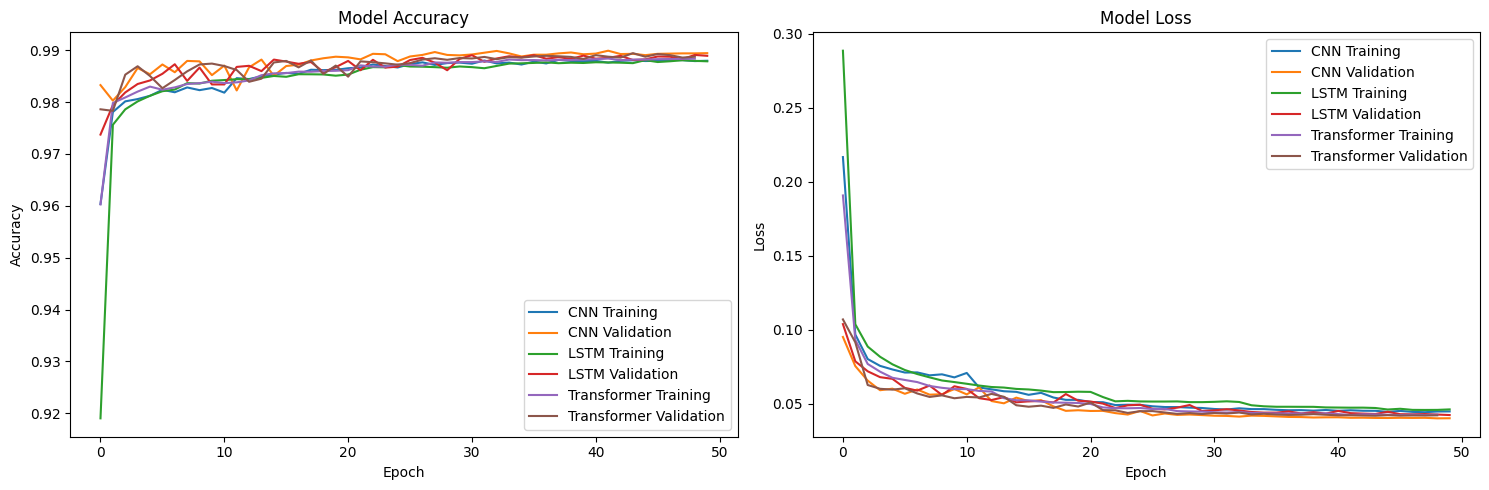

In [52]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='CNN Training')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Validation')
plt.plot(lstm_history.history['accuracy'], label='LSTM Training')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Validation')
plt.plot(transformer_history.history['accuracy'], label='Transformer Training')
plt.plot(transformer_history.history['val_accuracy'], label='Transformer Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='CNN Training')
plt.plot(cnn_history.history['val_loss'], label='CNN Validation')
plt.plot(lstm_history.history['loss'], label='LSTM Training')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation')
plt.plot(transformer_history.history['loss'], label='Transformer Training')
plt.plot(transformer_history.history['val_loss'], label='Transformer Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

1217/1217 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


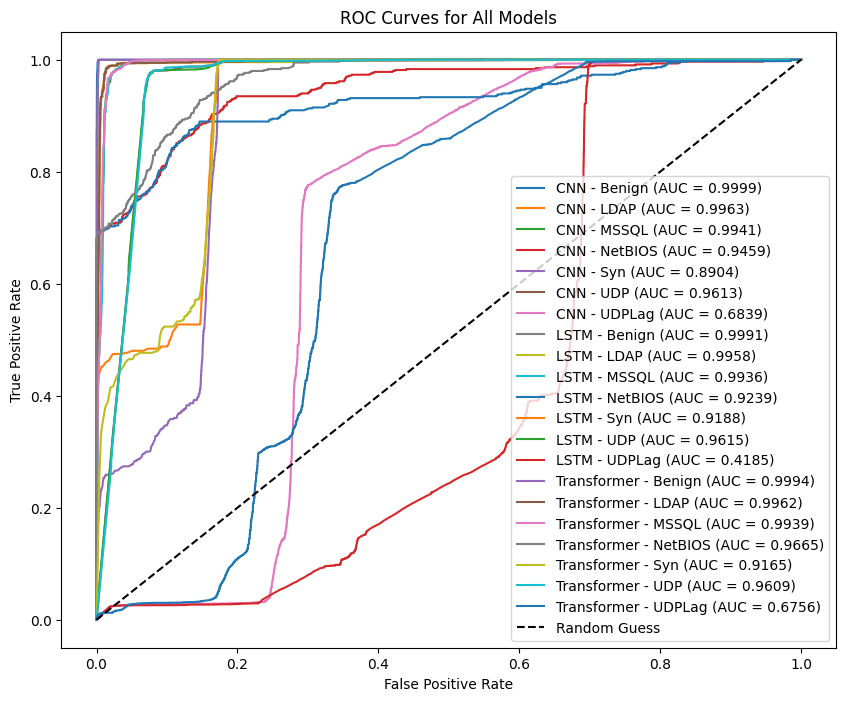

In [53]:
# Initialize plot for ROC curves
plt.figure(figsize=(10, 8))

# Generate ROC curves for each model
for model, model_name in zip([cnn_model, lstm_model, transformer_model], ['CNN', 'LSTM', 'Transformer']):
    y_pred_prob = model.predict(X_test_reshaped)
    
    # Plot ROC curve for each class
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test_cat[:, i], y_pred_prob[:, i])
        roc_auc = roc_auc_score(y_test_cat[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'{model_name} - {label_map[i]} (AUC = {roc_auc:.4f})')

# Add random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.show()

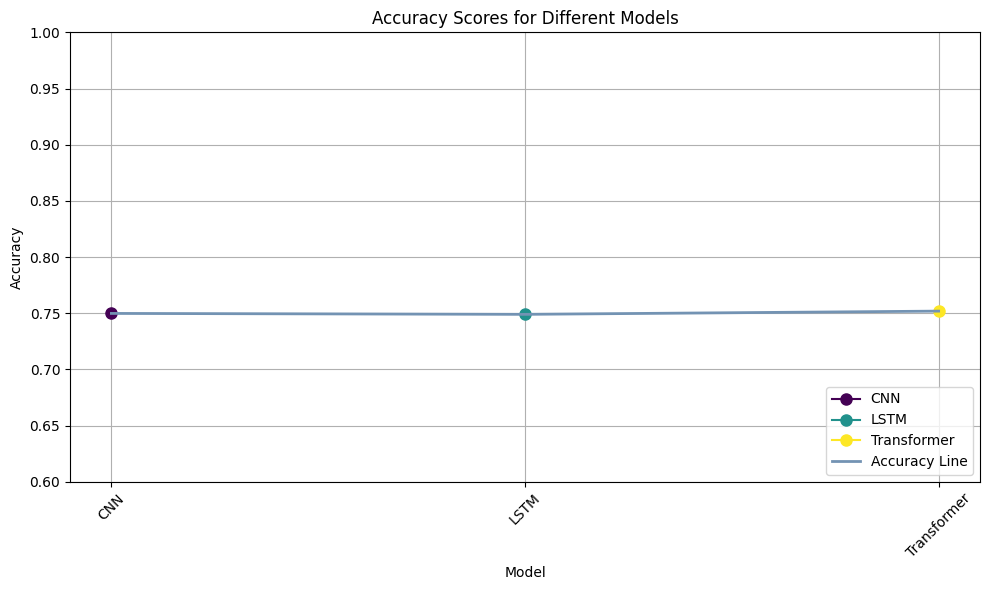

In [54]:
models = scores['Model']
accuracy = scores['Accuracy']

# Generate a color map
colors = cm.viridis(np.linspace(0, 1, len(models)))

# Plotting the accuracy points with color for each model
plt.figure(figsize=(10, 6))
for i, (model, acc) in enumerate(zip(models, accuracy)):
    plt.plot(model, acc, marker='o', color=colors[i], markersize=8, label=model)

# Adding a line that passes through the points
plt.plot(models, accuracy, linestyle='-', color='#7393B3', linewidth=2, label="Accuracy Line")

# Customizing the plot
plt.title("Accuracy Scores for Different Models")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0.6, 1) 
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot with legend at the bottom right
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # Remove duplicate labels
plt.legend(unique_labels.values(), unique_labels.keys(), loc="lower right")

# Show the plot
plt.tight_layout()
plt.show()

### Export the Best Model (Random Forest) for Deployment


In [55]:
# Identify the best model based on accuracy
best_model_idx = np.argmax(scores['Accuracy'])
best_model_name = scores.iloc[best_model_idx]['Model']
print(f"\nBest model based on accuracy: {best_model_name}")

# Save the best model
if best_model_name == "CNN":
    best_model = cnn_model
elif best_model_name == "LSTM":
    best_model = lstm_model
else:
    best_model = transformer_model

# Save the model
best_model.save(f'{best_model_name}_ddos_model.h5')
print(f"Best model saved as '{best_model_name}_ddos_model.h5'")

# For compatibility with other systems, also save using pickle
with open(f'{best_model_name}_ddos_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print(f"Model also saved as '{best_model_name}_ddos_model.pkl'")


Best model based on accuracy: Transformer
Best model saved as 'Transformer_ddos_model.h5'
Model also saved as 'Transformer_ddos_model.pkl'


### Recommendation


### Conclusion

Through this project, I evaluated several machine learning models for DDoS attack detection, aiming to identify the most effective model for classifying various types of DDoS attacks. The results provide insights into the performance of each model, and can help in building more robust cybersecurity systems that are capable of detecting and defending against DDoS attacks in real-world networks.

For more information about the dataset, you can visit the official [CICDDoS2019 Dataset Page](https://www.unb.ca/cic/datasets/ddos-2019.html).